In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import colorsys
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

stimrespdecodingfilename = 'D:\\stimdecoding_resp.csv'
stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stimbufferdecodingfilename = 'D:\\stimdecoding_25s_buffer.csv'
stimnobufferdecodingfilename = 'D:\\stimdecoding_25s_nobuffer.csv'
stimnotrimdecodingfilename = 'D:\\stimdecoding_25s_notrim.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

# Automated Phases

In [2]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
    
print(training_days_recorded['BS_59'])

  6%|▌         | 41/661 [00:00<00:06, 96.26it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
100%|██████████| 101/101 [00:00<00:00, 105.33it/s]

[]


In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

In [4]:
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))#danimals))
#animals = danimals
#animals = tuninganimalnames

['BS_61']
['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']


['BS_40',
 'BS_41',
 'BS_42',
 'BS_49',
 'BS_50',
 'BS_51',
 'BS_56',
 'BS_59',
 'BS_61',
 'BS_67',
 'BS_70',
 'BS_72',
 'BS_87',
 'BS_108',
 'DS_15',
 'DS_19']

In [5]:
def getExpertDays(animalBehaviors,animal):
    days = np.sort([k for k in animalBehaviors[animal].sessions])
    num_days = np.max(days)#len(days)
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    #############################################################
    #                   Find prereversal expert                 #
    #############################################################
    
    pre_expert_days = []
    
    if np.isfinite(reversal):
        days_to_check = np.sort(list(range(1,reversal)))[::-1]
    else:
        days_to_check = np.sort(list(range(1,num_days+1)))[::-1]
        reversal = np.max(days_to_check)+1
    days_to_check = days_to_check[np.isin(days_to_check,list(animalBehaviors[animal].sessions.keys()))]
    for day in days_to_check:
        outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
        
        exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
        if exceptionTrials is None:
            valid_trials_mask = ilep.getActiveTrials(outcomes)
        else:
            valid_trials_mask = exceptionTrials
        trimmed_outcomes = outcomes[valid_trials_mask]
        
        PCt,dpt = ilep.pcdpFromOutcomes(trimmed_outcomes)
        
        if PCt >= 0.7 and dpt >= 1.5:
            if np.isfinite(reversal):
                [pre_expert_days.append(d) for d in list(range(day,reversal+1))]
            else:
                [pre_expert_days.append(d) for d in list(range(day,np.max(days_to_check)+1))]
        elif day != days_to_check[0]:
            pass#break
    #if len(pre_expert_days)>0:
    #    pre_expert_days = np.concatenate((pre_expert_days))
    pre_expert_days = np.sort(np.unique(pre_expert_days))[::-1]
    pre_expert_days = pre_expert_days[np.isin(pre_expert_days,list(animalBehaviors[animal].sessions.keys()))]
        
    ############### Exceptions for specific animals ##################
    
    if animal == 'BS_40':
        pre_expert_days = np.array([17,16])
    if animal == 'BS_42':
        pre_expert_days = np.array([6,5])
    if animal == 'BS_50':
        pre_expert_days = np.array([11,10])
        
    #############################################################
    #                  Find postreversal expert                 #
    #############################################################
    
    if not np.isfinite(reversal):
        return pre_expert_days,[]
    
    post_expert_days = []
    days_to_check = np.sort(list(range(reversal+1,num_days+1)))[::-1]
    days_to_check = days_to_check[np.isin(days_to_check,list(animalBehaviors[animal].sessions.keys()))]
    for day in days_to_check:
        outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
        valid_trials_mask = ilep.getActiveTrials(outcomes)
        trimmed_outcomes = outcomes[valid_trials_mask]
        
        PCt,dpt = ilep.pcdpFromOutcomes(trimmed_outcomes)
        
        if PCt >= 0.7 and dpt >= 1.5:
            #post_expert_days.append(day)
            #if day == days_to_check[1]:
            [post_expert_days.append(d) for d in list(range(day,num_days+1))]
                #post_expert_days.append(day+1)
        elif day != days_to_check[0]:
            pass#break
    #if len(post_expert_days)>0:
    #    post_expert_days = np.concatenate((post_expert_days))
    post_expert_days = np.sort(np.unique(post_expert_days))[::-1]
    post_expert_days = post_expert_days[np.isin(post_expert_days,list(animalBehaviors[animal].sessions.keys()))]
        
    ############### Exceptions for specific animals ##################
    
    if animal == 'BS_49':
        post_expert_days = np.array([20,19,18])
    if animal == 'DS_28':
        post_expert_days = np.array([35])
        
    return pre_expert_days,post_expert_days

In [6]:
def getPCDPfromBehavior(animalBehaviors,animal,days,expert):
    cond = np.full_like(days,np.nan,dtype='float')
    cond_pc = np.full_like(days,np.nan,dtype='float')
    if not animal in animalBehaviors:
        return cond,cond_pc
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
        
    #We will remove the duplicate reversal day because we will calculate both
    #pre and post reversal when we get there at once
    days = np.unique(days)
    
    for idx,day in enumerate(days):
        if not day in animalBehaviors[animal].sessions:
            continue
            
        #We still want to put the post-reversal days in the right place, so we have to account
        #for the double reversal day
        if hasattr(animalBehaviors[animal],'reversal') and day > animalBehaviors[animal].reversal:
            idx+=1
            
        ########## Pre/Postreversal ##########
        if day != reversal:
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            #We will trim for active trials only on expert days
            exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
            if not exceptionTrials is None:
                pass#print(f"Trimming via exception trials")
                valid_trials_mask = exceptionTrials
                outcomes = outcomes[valid_trials_mask]
            elif day in expert:
                valid_trials_mask = ilep.getActiveTrials(outcomes)
                outcomes = outcomes[valid_trials_mask]

            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))

            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            #print(dp)
            if not exceptionTrials is None:
                pass#print(f"PC is {pc} dp is {dp}")

            cond[idx] = dp
            cond_pc[idx] = pc
            
        ########## Switch ##########
        if day == reversal:
            trials_per_session = animalBehaviors[animal].sessions[day].trials_per_session
            pre_reversal_trials = range(int(trials_per_session[0]))
            post_reversal_trials = range(int(trials_per_session[0]),int(np.sum(trials_per_session)))
            
            #Prereversal
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            outcomes = outcomes[pre_reversal_trials]
            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))
            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            cond[idx] = dp
            cond_pc[idx] = pc

            #Postreversal
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            outcomes = outcomes[post_reversal_trials]
            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))
            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            cond[idx+1] = dp
            cond_pc[idx+1] = pc
            
    return cond,cond_pc

BS_40
BS_41


../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


BS_42
BS_49
14
14
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 14 15 16 17 18]
BS_50


../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


BS_51
BS_56
BS_59
BS_67


../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


BS_70
BS_72
BS_87
BS_108
DS_15
DS_19


../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


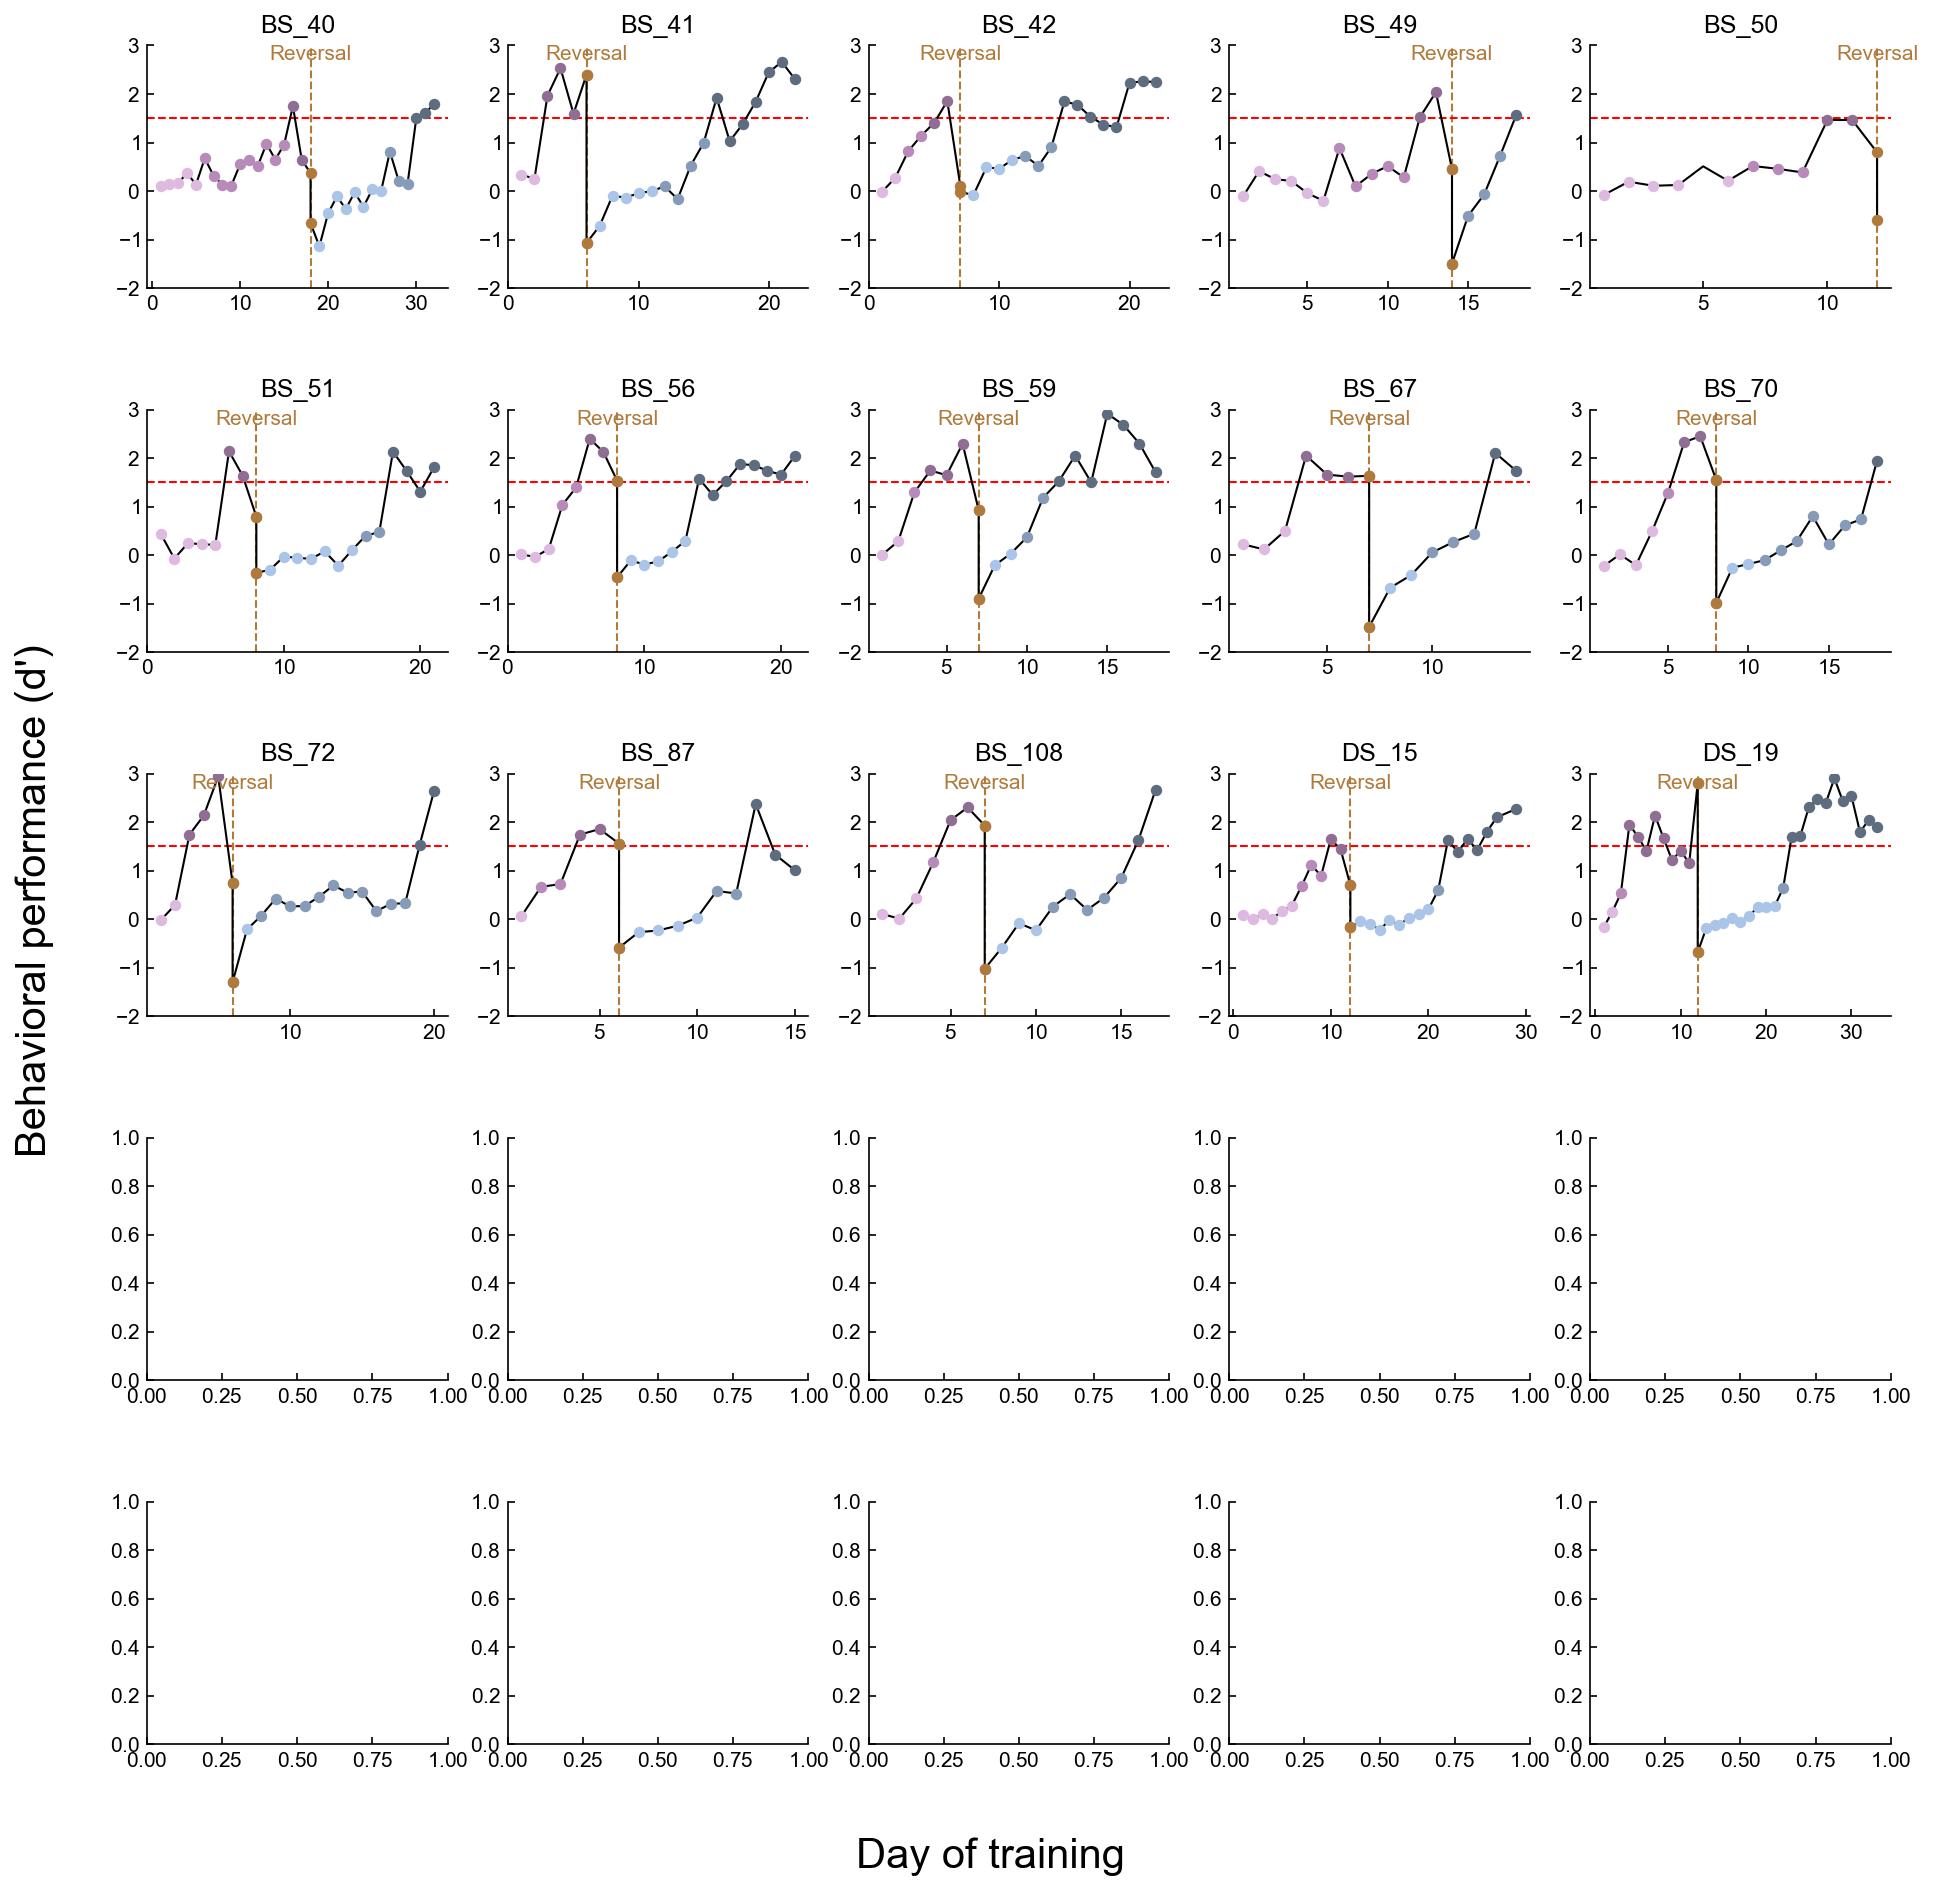

In [7]:
animalPhases = dict()

animalPreThresh = dict()
animalPostThresh = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(5,5,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(5),range(5))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

for animalidx,animal in enumerate(animals):
    print(animal)
    
    animalPhases[animal] = SimpleNamespace()
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    days = [k for k in animalBehaviors[animal].sessions]
    if np.isfinite(reversal):
        days.append(reversal)
    days = np.sort(days)
    
    if animal == 'BS_49':
        print(animalBehaviors[animal].reversal)
        print(reversal)
        print(days)
    
    pre_exp,post_exp = getExpertDays(animalBehaviors,animal)
    expert_days = np.concatenate((pre_exp,post_exp))
    dp_list,pc_list = getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
            
    ############### Calculation of learning phases ###################
    
    pre_reversal_days_mask = np.less(days,reversal)
    post_reversal_days_mask = np.greater(days,reversal)
    
    pre_reversal_dp_list = dp_list[pre_reversal_days_mask]
    post_reversal_dp_list = dp_list[post_reversal_days_mask]
    if np.isfinite(reversal):
        pre_switch_dp = dp_list[reversal-1]
        post_switch_dp = dp_list[reversal]
    else:
        pre_switch_dp = dp_list[len(dp_list)-1]
        post_switch_dp = []
        
#     print(f"reversal at {reversal}")
#     print(f"pre_reversal list is {pre_reversal_dp_list}")
    
    pre_rev_dp_concat = pre_reversal_dp_list#np.concatenate((pre_reversal_dp_list,pre_switch_dp))
    pre_rev_min = min(np.min(pre_reversal_dp_list),0)
    pre_rev_max = max(np.max(pre_reversal_dp_list),1.5)
    pre_reversal_dp_thresh = pre_rev_min + 0.3 * (pre_rev_max - pre_rev_min)
    post_rev_dp_concat = pre_reversal_dp_list#np.concatenate((post_reversal_dp_list,post_switch_dp))
#     print(f"post_rev dp list is {post_reversal_dp_list}")
    try:
        #post_rev_min = min(np.min(post_reversal_dp_list),0)
        post_rev_min = post_switch_dp
        post_rev_max = max(np.max(post_reversal_dp_list),1.5)
        post_reversal_dp_thresh = post_rev_min + 0.3 * (post_rev_max - post_rev_min)
    except:
        post_rev_min = np.nan
        post_rev_max = np.nan
        post_reversal_dp_thresh = np.Inf
        
    animalPreThresh[animal] = pre_reversal_dp_thresh
    animalPostThresh[animal] = post_reversal_dp_thresh

    pre_late_days_mask = np.greater_equal(pre_reversal_dp_list,pre_reversal_dp_thresh)
    post_late_days_mask = np.greater_equal(post_reversal_dp_list,post_reversal_dp_thresh)
    
    ############ Export final results to a list of days ############
    
    pre_reversal_days = np.where(pre_reversal_days_mask)[0] + 1
    post_reversal_days = np.where(post_reversal_days_mask)[0] # No +1 because double reversal day
    
    pre_expert_days = np.sort(pre_exp)
    post_expert_days = np.sort(post_exp)
    
    pre_late_days = np.where(pre_late_days_mask)[0] + 1
    post_late_days = np.where(post_late_days_mask)[0] + 1 + reversal # No +1 because adding reversal. +1 because double reversal
    
#     print(f"pre_reversal list is {pre_reversal_dp_list}")
#     print(f"post_reversal list is {post_reversal_dp_list}")
#     print(f"pre_late days are {pre_late_days}")
#     print(f"post_late days are {post_late_days}")
    
    if len(pre_late_days)>0:
        last_day_late = reversal
        if not np.isfinite(reversal):
            last_day_late = np.max(days)
#             print(f"last day = {last_day_late}")
        pre_late_days = np.arange(np.min(pre_late_days),last_day_late)
    if len(post_late_days)>0:
        post_late_days = np.arange(np.min(post_late_days),max(days))
    pre_late_days = pre_late_days[np.logical_not(np.isin(pre_late_days,pre_expert_days))]
    post_late_days = post_late_days[np.logical_not(np.isin(post_late_days,post_expert_days))]
    
    pre_early_days = pre_reversal_days[np.logical_not(np.isin(pre_reversal_days,pre_late_days))]
    post_early_days = post_reversal_days[np.logical_not(np.isin(post_reversal_days,post_late_days))]
    pre_early_days = pre_early_days[np.logical_not(np.isin(pre_early_days,pre_expert_days))]
    post_early_days = post_early_days[np.logical_not(np.isin(post_early_days,post_expert_days))]
    
    if False:#animal in ['BS_49']:
        print(animal)
        print(f"reversal is {reversal}")
        print(f"dps are {dp_list}")

        print(f"Pre-reversal days mask: {pre_reversal_days_mask}")
        print(f"Post-reversal days mask: {post_reversal_days_mask}")

        print(f"Pre-reversal dps: {pre_reversal_dp_list}")
        print(f"Post-reversal dps: {post_reversal_dp_list}")

        print(f"Pre-reversal threshold: {pre_reversal_dp_thresh}")
        print(f"Post-reversal threshold: {post_reversal_dp_thresh}")

        print(f"Pre-reversal days: {pre_reversal_days}")
        print(f"Post-reversal days: {post_reversal_days}")

        print(f"Pre-early days: {pre_early_days}")
        print(f"Post-early days: {post_early_days}")

        print(f"Pre-late days: {pre_late_days}")
        print(f"Post-late days: {post_late_days}")

        print(f"Pre-expert days: {pre_expert_days}")
        print(f"Post-expert days: {post_expert_days}")
        
    #Handle one particular exception for BS_50 due to animal not behaving
    if animal == 'BS_50':
        pre_early_days = list(pre_early_days)
        pre_late_days = list(pre_late_days)
        pre_late_days.remove(5)
        #I have verified that day is is below the pre-threshold
        pre_late_days.remove(6)
        pre_early_days.append(6)
        pre_early_days = np.sort(pre_early_days)
        pre_late_days = np.sort(pre_late_days)
    if animal == 'BS_173':
        pre_expert_days = np.array([7,9,10,11])
    if animal == 'BS_175':
        pre_expert_days = np.array([4,6,7,9,10,11])
        
    animalPhases[animal].pre_early_days = pre_early_days
    animalPhases[animal].pre_late_days = pre_late_days
    animalPhases[animal].pre_expert_days = pre_expert_days
    if np.isfinite(reversal):
        animalPhases[animal].switch_days = [reversal]
    else:
        animalPhases[animal].switch_days = []
    animalPhases[animal].post_early_days = post_early_days
    animalPhases[animal].post_late_days = post_late_days
    animalPhases[animal].post_expert_days = post_expert_days
    
    #PLOTTING_PHASE_COLORS = ['k','r','g']*2
    PLOTTING_PHASE_COLORS = PHASE_COLORS
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,dp_list,color='k',lw=1)
        
        #Pre Early
        pre_early = np.isin(days,pre_early_days)
        ax.scatter(days[pre_early],dp_list[pre_early],color=PLOTTING_PHASE_COLORS[0],s=20,zorder=10)
        
        #Pre Late
        pre_late = np.isin(days,pre_late_days)
        ax.scatter(days[pre_late],dp_list[pre_late],color=PLOTTING_PHASE_COLORS[1],s=20,zorder=10)
        #ax.axhline(animalPreThresh[animal],c=PHASE_COLORS[1],linestyle='--',lw=1,zorder=-20)
        
        #Pre Expert
        pre_expert = np.isin(days,pre_expert_days)
        ax.scatter(days[pre_expert],dp_list[pre_expert],color=PLOTTING_PHASE_COLORS[2],s=20,zorder=10)
        
        #Post Early
        post_early = np.isin(days,post_early_days)
        ax.scatter(days[post_early],dp_list[post_early],color=PLOTTING_PHASE_COLORS[3],s=20,zorder=10)
        
        #Post Late
        post_late = np.isin(days,post_late_days)
        ax.scatter(days[post_late],dp_list[post_late],color=PLOTTING_PHASE_COLORS[4],s=20,zorder=10)
        #ax.axhline(animalPostThresh[animal],c=PHASE_COLORS[4],linestyle='--',lw=1,zorder=-20)
        
        #Post Expert
        post_expert = np.isin(days,post_expert_days)
        ax.scatter(days[post_expert],dp_list[post_expert],color=PLOTTING_PHASE_COLORS[5],s=20,zorder=10)
        
        #Switch
        switch = np.equal(days,reversal)
        ax.scatter(days[switch],dp_list[switch],color=SWITCH_COLOR,s=20,zorder=10)
        #ax.scatter(days[switch],dp_list[switch],color='b',s=20,zorder=10)

        ax.set_ylim([-2,3])
        
        ax.text(reversal,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
        ax.axvline(reversal,c=SWITCH_COLOR,linestyle='--',lw=1,zorder=-10)
        
        ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-10)
        
        #days_recorded = training_days_recorded[animal]
        #ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)
        ax.set_title(animal)
        
        #days_recorded = training_days_recorded[animal]
        #ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)
        
        if animal in ['DS_15']:
            pass#ax.text(1,-1.5,'NOTE: lost behavior data',verticalalignment='bottom',horizontalalignment='left')
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    #plt.savefig(os.path.join('D:\\\\TempFigures','Automated Learning Phases 2.pdf'),transparent=False,facecolor="white")
    #plt.savefig(os.path.join('D:\\\\TempFigures','Automated Learning Phases 2 Danimals.pdf'),transparent=False,facecolor="white")
    #plt.savefig(os.path.join('D:\\\\TempFigures','Automated Learning Phases 2 Tuning Animals.pdf'),transparent=False,facecolor="white")
    pass

In [15]:
animal = 'DS_19'
day = 5#8
getTrialsPerDayPerAnimal(animalBehaviors,animal,[day],np.concatenate(getExpertDays(animalBehaviors,animal)))

{5: array([400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412,
        413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425,
        426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
        439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451,
        452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464,
        465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477,
        478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490,
        491, 492, 493, 494, 495, 496, 497, 498, 499])}

In [11]:
getExpertDays(animalBehaviors,'BS_173')

C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:153: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


(array([15, 14, 13, 12, 11, 10,  9,  8,  7]), array([28]))

In [8]:
def getTrialsPerDayPerAnimal(animalBehaviors,animal,days,expert_days):    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
        
    #We will remove the duplicate reversal day because we will calculate both
    #pre and post reversal when we get there at once
    days = np.unique(days)
    
    trials_list_per_day = dict()
    
    for day in days:
        if not day in animalBehaviors[animal].sessions:
            continue
            
        outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
        valid_trials = np.array(range(len(outcomes)))
        ########## Pre/Postreversal ##########
        if day != reversal:
            
            exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
            if not exceptionTrials is None:
                valid_trials = exceptionTrials
            elif day in expert_days:
                valid_trials = ilep.getActiveTrials(outcomes)
        
        trials_list_per_day[day] = valid_trials
        
    return trials_list_per_day




trialsPerDay = dict()
for animal in animalBehaviors:
    try:
        days = [k for k in animalBehaviors[animal].sessions]

        pre_exp,post_exp = getExpertDays(animalBehaviors,animal)
        expert_days = np.concatenate((pre_exp,post_exp))

        trials_list = getTrialsPerDayPerAnimal(animalBehaviors,animal,days,expert_days)

        trialsPerDay[animal] = trials_list
        
    except Exception as e:
        print(f"{animal} has exception {e}")
        if animal == 'BS_73':
            raise e
        trialsPerDay[animal] = None
pass

../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


In [9]:
trialsPerDay
with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'wb') as f:
        pickle.dump(trialsPerDay, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'rb') as f:
        trialsPerDayLoaded = pickle.load(f)

# Experimentalist Derived Phases

In [34]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
    
print(training_days_recorded['BS_59'])

 74%|███████▍  | 397/533 [00:02<00:00, 185.99it/s]


KeyboardInterrupt: 

In [3]:
firstExpert = SimpleNamespace()
firstExpert.pre = dict()
firstExpert.post = dict()

#Tuning Animals
firstExpert.pre['BS_173'] = 14
firstExpert.pre['BS_175'] = 10
firstExpert.pre['BS_187'] = 6
firstExpert.pre['BS_188'] = 5
firstExpert.pre['BS_213'] = 6
firstExpert.pre['BS_214'] = np.Inf
firstExpert.pre['TH_217'] = 18
firstExpert.pre['AE_235'] = 8
firstExpert.pre['AE_236'] = 9
firstExpert.pre['TH_237'] = 7

firstExpert.post['BS_173'] = 28
firstExpert.post['BS_175'] = 27
firstExpert.post['BS_187'] = 15
firstExpert.post['BS_188'] = 18
firstExpert.post['BS_213'] = np.Inf
firstExpert.post['BS_214'] = np.Inf
firstExpert.post['TH_217'] = np.Inf ### Pending
firstExpert.post['AE_235'] = np.Inf ### Pending
firstExpert.post['AE_236'] = np.Inf ### Pending
firstExpert.post['TH_237'] = np.Inf ### Pending

#Dual recording animals
firstExpert.pre['BS_40'] = 16 # Maybe 17
firstExpert.pre['BS_41'] = 4
firstExpert.pre['BS_42'] = 5
firstExpert.pre['BS_49'] = 12
firstExpert.pre['BS_50'] = 10
firstExpert.pre['BS_51'] = 6
firstExpert.pre['BS_56'] = 6
firstExpert.pre['BS_59'] = 4
firstExpert.pre['BS_67'] = 4 #Maybe 5. 68% and 1.6
firstExpert.pre['BS_70'] = 6
firstExpert.pre['BS_72'] = 4
firstExpert.pre['BS_87'] = 4
firstExpert.pre['BS_108'] = 5
firstExpert.pre['DS_15'] = 9
firstExpert.pre['DS_19'] = 10

firstExpert.post['BS_40'] = 30
firstExpert.post['BS_41'] = 16
firstExpert.post['BS_42'] = 15
firstExpert.post['BS_49'] = 18
firstExpert.post['BS_50'] = np.Inf
firstExpert.post['BS_51'] = 17
firstExpert.post['BS_56'] = 14
firstExpert.post['BS_59'] = 13
firstExpert.post['BS_67'] = 13
firstExpert.post['BS_70'] = 18
firstExpert.post['BS_72'] = 19
firstExpert.post['BS_87'] = 13
firstExpert.post['BS_108'] = 15
firstExpert.post['DS_15'] = 25 #Double-check this
firstExpert.post['DS_19'] = 23

In [4]:
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']

animalnames = dualanimalnames

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#Dual Recording Animals
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
# animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
# animals['DS_15'].reversal = 12
# animals['DS_19'].reversal = 12

# #Opsin Animals
# animals['BS_86'].reversal = 14
# animals['BS_92'].reversal = 9
# animals['BS_100'].reversal = 11
# animals['BS_103'].reversal = 8
# animals['BS_111'].reversal = 8
# animals['BS_119'].reversal = 10
# animals['BS_123'].reversal = 9
# animals['BS_128'].reversal = 6
# animals['BS_131'].reversal = 14
# animals['BS_139'].reversal = 10
# animals['BS_163'].reversal = 13
# animals['BS_165'].reversal = np.Inf
# animals['BS_174'].reversal = 14
# animals['BS_179'].reversal = 16
# animals['BS_191'].reversal = 10
# animals['BS_192'].reversal = 7

# #Tuning Animals
# animals['BS_173'].reversal = 15
# animals['BS_175'].reversal = 11
# animals['BS_187'].reversal = 8
# animals['BS_188'].reversal = 8
# animals['BS_213'].reversal = 8
# animals['BS_214'].reversal = np.Inf
# animals['TH_217'].reversal = 20
# animals['AE_235'].reversal = np.Inf ### Pending
# animals['AE_236'].reversal = np.Inf ### Pending
# animals['TH_237'].reversal = np.Inf ### Pending

print([a for a in animals])

['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56', 'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108']


BS_40
6
BS_41
3
BS_42
3
BS_49
2
BS_50
7
BS_51
6
BS_56
4
BS_59
3
BS_67
4
BS_70
5
BS_72
3
BS_87
4
BS_108
3


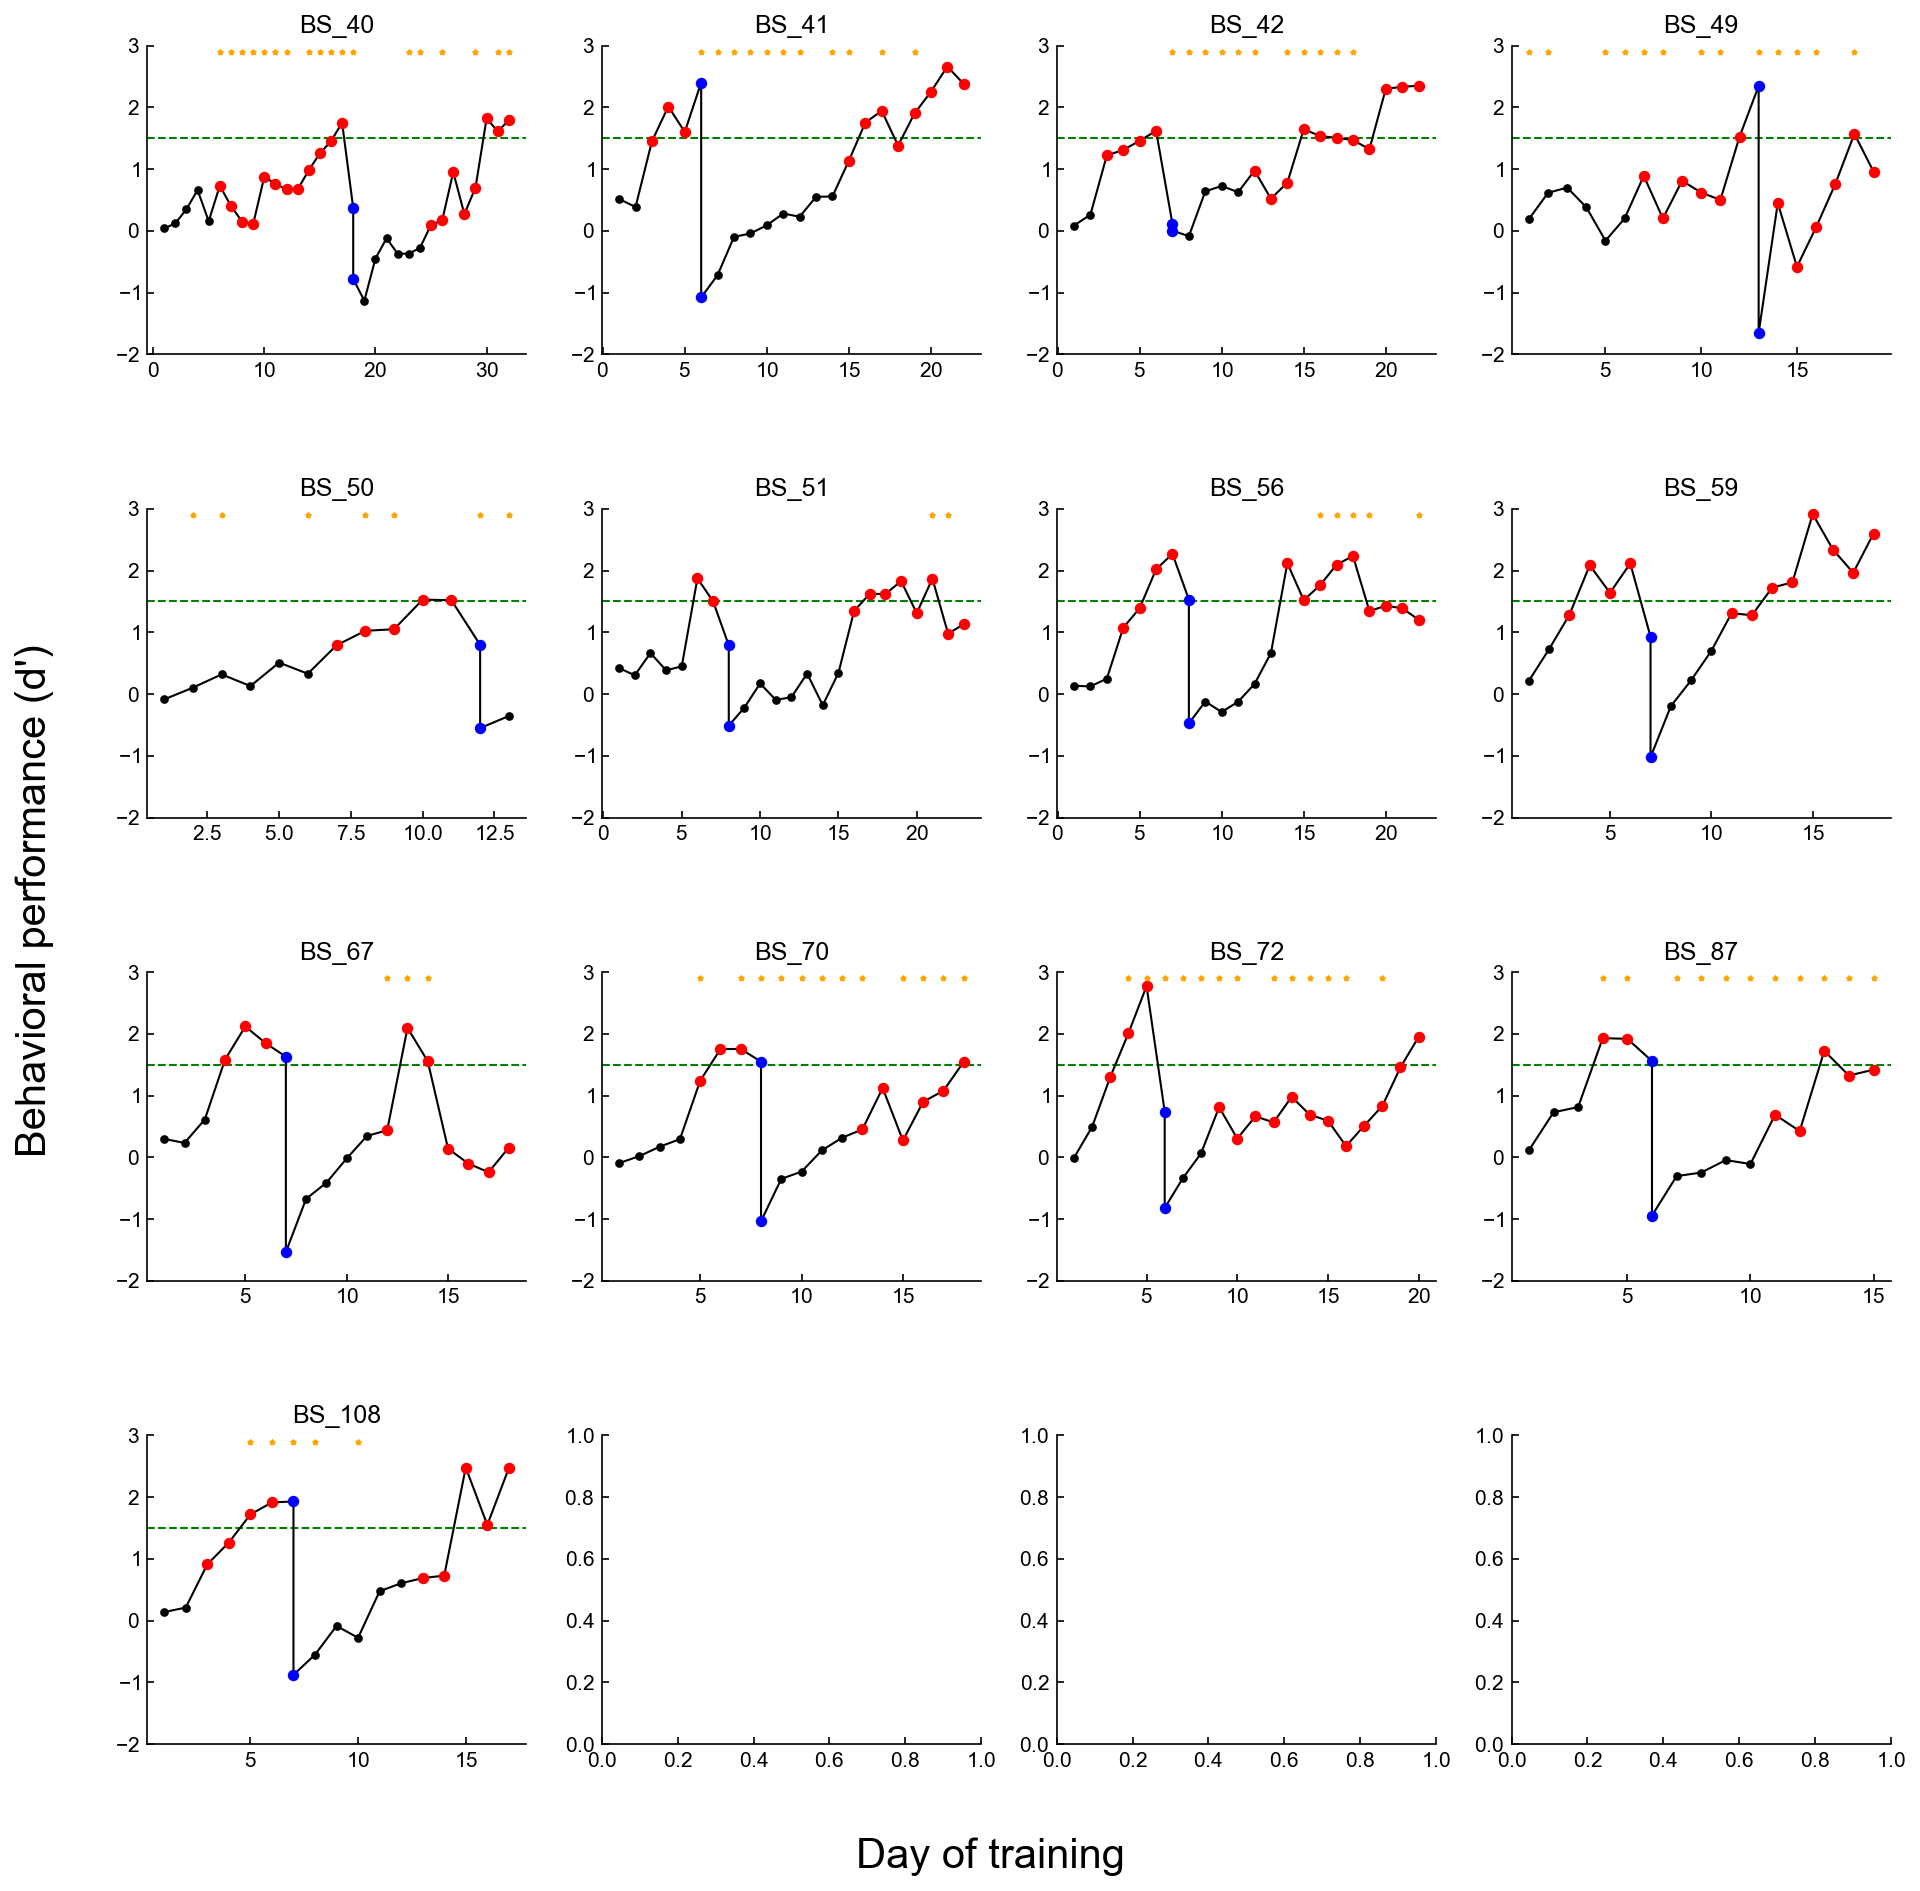

In [5]:
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMTTotal.csv')
#filename = os.path.join('D:\\\\DataForJMTTotal.csv')
csv = pd.read_csv(filename)

prethresholds = dict()
postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal or np.isnan(animals[animal].reversal):
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[1.5])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    try:
        maxperf = np.nanmax(np.concatenate((postreversaldps,[1.5])))
        minperf = np.nanmin(postreversaldps)
    except:
        print(animal+' has no post-reversal')
        maxperf = np.nan
        minperf = np.nan
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    prethresholds[animal] = prethreshold
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
        
    print(premiddlefirstday)
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal == 'BS_49':
        premiddlefirstday = 7
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday), np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    #plt.savefig(os.path.join('D:\\\\TempFigures','EIL Learning Phases.pdf'),transparent=False,facecolor="white")
    pass

In [9]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in np.concatenate((dualanimalnames,['DS_15','DS_19'])):#np.concatenate((dualanimalnames,danimals)):
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 592/592 [00:02<00:00, 210.54it/s]


In [10]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and animal in ['DS_15','DS_19']:
            EILphases[idx] = 'pre expert'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in animalPhases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in animalPhases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in animalPhases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and animal in ['DS_15','DS_19']:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1440/1440 [00:08<00:00, 171.75it/s]

errors for: []


In [9]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < firstExpert.pre[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training >= firstExpert.pre[sessionfile.meta.animal]:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < firstExpert.post[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training >= firstExpert.post[sessionfile.meta.animal]:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 2894/2894 [00:16<00:00, 179.41it/s]

errors for: ['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'DS_13' 'DS_15' 'DS_16' 'DS_17' 'DS_19' 'DS_22'
 'DS_23' 'DS_24' 'DS_27' 'DS_28']


In [11]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

FRb_preearly = []
FRb_prelate = []
FRb_preexpert = []
FRb_postearly = []
FRb_postlate = []
FRb_postexpert = []

FRe_preearly = []
FRe_prelate = []
FRe_preexpert = []
FRe_postearly = []
FRe_postlate = []
FRe_postexpert = []

FReT_preearly = []
FReT_prelate = []
FReT_preexpert = []
FReT_postearly = []
FReT_postlate = []
FReT_postexpert = []

FReNT_preearly = []
FReNT_prelate = []
FReNT_preexpert = []
FReNT_postearly = []
FReNT_postlate = []
FReNT_postexpert = []

FRt_preearly = []
FRt_prelate = []
FRt_preexpert = []
FRt_postearly = []
FRt_postlate = []
FRt_postexpert = []

ramping_preearly = []
ramping_prelate = []
ramping_preexpert = []
ramping_postearly = []
ramping_postlate = []
ramping_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
            
    #if not sessionfile.meta.animal in animalstouse:
    #    continue
    #if sessionfile.meta.animal in tuninganimalnames:
    #    continue
        
    if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
        continue
        
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
        continue
        
    if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
        continue
        
    if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
        continue
        
    if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
        continue
        
    if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
        continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
        
    #if not sessionfile.meta.animal in ['BS_213','BS_214']:
    #    continue
    
    #else:
    #    print(ilep.generateDateString(sessionfile))
    #    print(len(sessionfile.clusters.good))
        
    #if np.isnan(accuracies[idx]):
    #    continue
        
    if EILphases[idx] == 'pre early':
        FRb_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preearly.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_preearly.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #temp = ( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )        
        #Dec_preearly.append(accuracies[idx])
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRb_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_prelate.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_prelate.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_preint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )                
        #Dec_preint.append(accuracies[idx])
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRb_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preexpert.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_preexpert.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_preexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_prelate.append(accuracies[idx])
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRb_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postearly.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postearly.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postearly.append(accuracies[idx])
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRb_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postlate.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postlate.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_postint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postint.append(accuracies[idx])
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRb_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postexpert.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postexpert.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postlate.append(accuracies[idx])
        postexpert_animals.append(sessionfile.meta.animal)
        
FRb_preearly = np.array(FRb_preearly)
FRb_prelate = np.array(FRb_prelate)
FRb_preexpert = np.array(FRb_preexpert)
FRb_postearly = np.array(FRb_postearly)
FRb_postlate = np.array(FRb_postlate)
FRb_postexpert = np.array(FRb_postexpert)

FRe_preearly = np.array(FRe_preearly)
FRe_prelate = np.array(FRe_prelate)
FRe_preexpert = np.array(FRe_preexpert)
FRe_postearly = np.array(FRe_postearly)
FRe_postlate = np.array(FRe_postlate)
FRe_postexpert = np.array(FRe_postexpert)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

FReT_preearly = np.array(FReT_preearly)
FReT_prelate = np.array(FReT_prelate)
FReT_preexpert = np.array(FReT_preexpert)
FReT_postearly = np.array(FReT_postearly)
FReT_postlate = np.array(FReT_postlate)
FReT_postexpert = np.array(FReT_postexpert)

FReNT_preearly = np.array(FReNT_preearly)
FReNT_prelate = np.array(FReNT_prelate)
FReNT_preexpert = np.array(FReNT_preexpert)
FReNT_postearly = np.array(FReNT_postearly)
FReNT_postlate = np.array(FReNT_postlate)
FReNT_postexpert = np.array(FReNT_postexpert)

ramping_preearly = np.array(ramping_preearly)
ramping_prelate = np.array(ramping_prelate)
ramping_preexpert = np.array(ramping_preexpert)
ramping_postearly = np.array(ramping_postearly)
ramping_postlate = np.array(ramping_postlate)
ramping_postexpert = np.array(ramping_postexpert)
ramping_preearly = ramping_preearly[np.isfinite(ramping_preearly)]
ramping_prelate = ramping_prelate[np.isfinite(ramping_prelate)]
ramping_preexpert = ramping_preexpert[np.isfinite(ramping_preexpert)]
ramping_postearly = ramping_postearly[np.isfinite(ramping_postearly)]
ramping_postlate = ramping_postlate[np.isfinite(ramping_postlate)]
ramping_postexpert = ramping_postexpert[np.isfinite(ramping_postexpert)]

# FRt_preearly = np.array(FRt_preearly)
# FRt_prelate = np.array(FRt_prelate)
# FRt_preexpert = np.array(FRt_preexpert)
# FRt_postearly = np.array(FRt_postearly)
# FRt_postlate = np.array(FRt_postlate)
# FRt_postexpert = np.array(FRt_postexpert)

#Dec_preearly = np.array(Dec_preearly)
#Dec_preint = np.array(Dec_preint)
#Dec_prelate = np.array(Dec_prelate)
#Dec_postearly = np.array(Dec_postearly)
#Dec_postint = np.array(Dec_postint)
#Dec_postlate = np.array(Dec_postlate)

1440it [00:08, 172.64it/s]


In [12]:
stim_resp_df = pd.read_csv(stimrespdecodingfilename)
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
stim_buffer_df = pd.read_csv(stimbufferdecodingfilename)
stim_nobuffer_df = pd.read_csv(stimnobufferdecodingfilename)
stim_notrim_df = pd.read_csv(stimnotrimdecodingfilename)
stim_notrim_df = pd.read_csv(stimnotrimdecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)

dec_df = pd.concat([stim_25s_df,choice_df])
#dec_df.set_index(['session'])#,'clust','categories'])

old_dec_filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-18FromCache.csv' #Old data
#old_dec_filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-20FromCache.csv' #Data not quite used for SfN
old_dec_df = pd.read_csv(old_dec_filename)

In [13]:
def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')
    
#getDataPoint(dec_df,'BS_108_1_AC.pickle',9,'stimulus','accuracy')

In [14]:
def getOldDataPoint(df,session,clust,column):
    df = df[df['sessions']==session]
    df = df[df['clusters']==clust]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')
    
#getOldDataPoint(old_dec_df,'BS_108_1_AC.pickle',9,'accuracies')

In [15]:
stim_acc = []
choice_acc = []
stim_acc_c = []
choice_acc_c = []
stim_acc_s = []
choice_acc_s = []
pval_stim_s = []
pval_choice_s = []
pval_stim_c = []
pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    #stim_accuracy = getOldDataPoint(old_dec_df,session,clust,'accuracies')
    choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    #stim_accuracy_c = getDataPoint(dec_df,session,clust,'stimulus','shuffled_control_accuracy')
    #choice_accuracy_c = getDataPoint(dec_df,session,clust,'response','shuffled_control_accuracy')
    
    #stim_accuracy_s = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_accuracy')
    #choice_accuracy_s = getDataPoint(dec_df,session,clust,'response','synthetic_control_accuracy')
    
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    #pvalue_stim_s = getOldDataPoint(old_dec_df,session,clust,'pvals')
    pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    pvalue_stim_c = getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
    #pvalue_stim_c = getOldDataPoint(old_dec_df,session,clust,'pvals')
    pvalue_choice_c = getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    stim_acc.append(stim_accuracy)
    choice_acc.append(choice_accuracy)
    
    #stim_acc_c.append(stim_accuracy_c)
    #choice_acc_c.append(choice_accuracy_c)
    
    #stim_acc_s.append(stim_accuracy_s)
    #choice_acc_s.append(choice_accuracy_s)
    
    pval_stim_s.append(pvalue_stim_s)
    pval_choice_s.append(pvalue_choice_s)
    
    pval_stim_c.append(pvalue_stim_c)
    pval_choice_c.append(pvalue_choice_c)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)
#stim_acc_c = np.array(stim_acc_c)
#choice_acc_c = np.array(choice_acc_c)
#stim_acc_s = np.array(stim_acc_s)
#choice_acc_s = np.array(choice_acc_s)
pval_stim_s = np.array(pval_stim_s)
pval_choice_s = np.array(pval_choice_s)
pval_stim_c = np.array(pval_stim_c)
pval_choice_c = np.array(pval_choice_c)

1440it [00:08, 164.21it/s]


# Calculate Task Encoder Cutoff

In [16]:
def get_TE_mask(acc,pval_s,pval_c):
    low_decoders = np.less(acc,0.5)
    low_accuracies = acc[low_decoders]
    low_magnitudes = np.absolute(low_accuracies-0.5)

    low_magnitudes = np.sort(low_magnitudes)
    task_encoder_threshold = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
    print('Task encoder threshold: '+str(task_encoder_threshold))

    is_finite = np.isfinite(acc)
    is_valid_pval = np.logical_and(np.less(pval_s,0.05) , np.less(pval_c,0.05))
    is_TE = np.greater_equal(acc,task_encoder_threshold)
    is_TE = np.logical_and(is_TE,is_finite)
    is_TE = np.logical_and(is_TE,is_valid_pval)
    return is_TE,task_encoder_threshold

is_TE_s,task_encoder_threshold_s = get_TE_mask(stim_acc,pval_stim_s,pval_stim_c)
is_TE_c,task_encoder_threshold_c = get_TE_mask(choice_acc,pval_choice_s,pval_choice_c)

Task encoder threshold: 0.5669977035930377
Task encoder threshold: 0.5790359432234433


Median  of TEs is 0.6116424378745571
Percent of TEs is 0.34097222222222223
Number  of TEs is 491


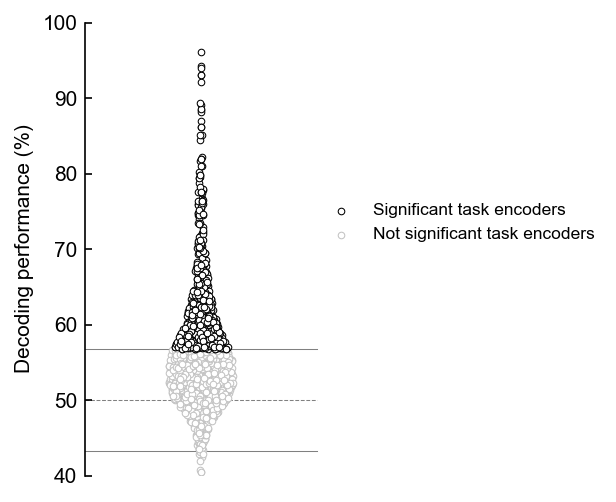

In [20]:
fig, ax = plt.subplots(figsize=(4,4))

X = np.ones_like(stim_acc)
_,Y = ilep.violin(X,stim_acc)
X,_ = ilep.violin(X,np.log10(stim_acc),width=0.35)

is_TE = is_TE_s
size=10
ax.scatter(X[is_TE], Y[is_TE], s=size, ec='black', fc='white', lw=0.5,zorder=0,label='Significant task encoders')
ax.scatter(X[np.logical_not(is_TE)], Y[np.logical_not(is_TE)], s=size, ec='#C3C3C3', fc='white', lw=0.5,zorder=-1,label='Not significant task encoders')

ax.set_xlim([0.5,2.5])
ax.set_xticks([])

ax.set_ylim([0.4,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])

ax.axhline(task_encoder_threshold_s,linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
ax.axhline(0.5,linestyle='--',color='grey',zorder=-10,lw=0.5,xmax=0.5)
ax.axhline(0.5-(task_encoder_threshold_s-0.5),linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
#ax.axhline(np.median(stim_acc[is_TE_s]),xmax=0.5,color='green')

print(f"Median  of TEs is {np.median(stim_acc[is_TE_s])}")
print(f"Percent of TEs is {np.mean(is_TE_s)}")
print(f"Number  of TEs is {np.sum(is_TE_s)}")

ax.legend(frameon=False,loc=(0.5,0.5))

ax.set_ylabel('Decoding performance (%)')
ax.spines['bottom'].set_visible(False)


#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Task encoders schematic inference buffer.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Task encoders schematic old decoding.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Task encoders schematic.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Task encoders schematic.png'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Task encoders choice schematic.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Task encoders choice schematic.png'),transparent=False,facecolor="white")

In [17]:
print(f"Nanpercent of TEs is {np.sum(is_TE_s) / np.sum(np.isfinite(stim_acc))}")

Nanpercent of TEs is 0.35683139534883723


In [18]:
pc_task_encoders = np.array([np.nan]*6)
total_phases = ['pre early','pre late','pre expert','post early','post late','post expert']
labels = ['Early','Late','Expert','Early','Late','Expert']
for phase_idx,phase in enumerate(total_phases):
    
    te_in_phase = 0
    cells_in_phase = 0
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
            continue
        if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
            continue
        if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue
        if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue

        if EILphases[idx] != phase:
            continue
            
        acc = getDataPoint(dec_df,session,clust,'stimulus','accuracy')
        #acc = getOldDataPoint(old_dec_df,session,clust,'accuracies')
        
        if np.isnan(acc):
            pass#continue
        
        #Require >= 100 trials
        conditions = ilep.getAllConditions(sessionfile,clust)
        if len(conditions['all_trials'].trials) < 100:
            pass#continue
            
        cells_in_phase += 1
        if is_TE[idx]:
            te_in_phase += 1
            
    print(f"n={te_in_phase}/{cells_in_phase}")
    
    pc_task_encoders[phase_idx] = np.sum(te_in_phase) / np.sum(cells_in_phase)

673it [00:04, 135.72it/s]


NameError: name 'is_TE' is not defined

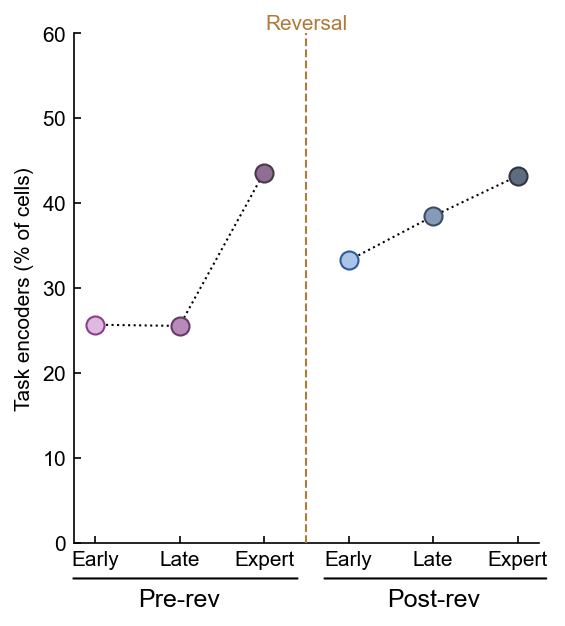

In [101]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
chosen_color='k'
ax.plot([0,1,2],pc_task_encoders[0:3]*100,color='k',linestyle=':',lw=1,alpha=1,zorder=-10)
ax.plot([3,4,5],pc_task_encoders[3:6]*100,color='k',linestyle=':',lw=1,alpha=1,zorder=-10)
#ax.scatter([0,1,2,3,4,5],pc_task_encoders*100,fc='white',ec=PHASE_COLORS,s=75)
for idx,pct in enumerate(pc_task_encoders):
    eye_color=PHASE_COLORS[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)

    summary_size=50
    summary_width=1
    
    ax.scatter(idx,pct*100,fc=eye_color,ec=border_color,s=75)
#ax.scatter([3,4,5],pc_task_encoders[3:6]*100,fc='white',ec=chosen_color,s=75)

ax.set_ylim([0,60])
ax.set_ylabel('Task encoders (% of cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#Wide mode
# ax.annotate('', xy=(0.0, -0.105), xycoords='axes fraction', xytext=(0.465, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.545, -0.105), xycoords='axes fraction', xytext=(1.0125, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# ax.text(xtick_pos_pre, -7.982793779389773, 'Pre-rev', ha='center', va='top', fontsize=12)
# ax.text(xtick_pos_post, -7.982793779389773, 'Post-rev', ha='center', va='top',  fontsize=12)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -7.982793779389773/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -7.982793779389773/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases inference buffer task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases old decoding task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 2 inference buffer task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 2  old decoding task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 3 inference buffer task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 3 inference buffer task encoders.png'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 3  old decoding task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 3  old decoding task encoders.png'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Experimentalist phases inference buffer task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Experimentalist phases old decoding task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 3 inference buffer task encoders 100 trials or greater.png'),transparent=False,facecolor="white")

#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 4 all trials.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 4 active trials.png'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 4 active trials danimals.png'),transparent=False,facecolor="white")

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Task encoders over learning.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Task encoders over learning.png'),transparent=False,facecolor="white")

# CR/NCR task encoders -- FRmod classifications

In [21]:
FRmod_baseline_median = np.nanmedian(FRmod_preearly)

NCR_pc_task_encoders = np.array([np.nan]*6)
CR_pc_task_encoders = np.array([np.nan]*6)
NCR_allpc_task_encoders = np.array([np.nan]*6)
CR_allpc_task_encoders = np.array([np.nan]*6)

phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for phase_idx,phase in enumerate(phases):
    
    CR_te_in_phase = 0
    CR_cells_in_phase = 0
    NCR_te_in_phase = 0
    NCR_cells_in_phase = 0
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
            continue
        if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
            continue
        if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue
        if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue

        if EILphases[idx] != phase:
            continue
            
        acc = getDataPoint(stim_25s_df,session,clust,'stimulus','accuracy')
        #acc = getOldDataPoint(old_dec_df,session,clust,'accuracies')
        
        if np.isnan(acc):
            pass#continue
        
        #Require >= 100 trials
        conditions = ilep.getAllConditions(sessionfile,clust)
        if len(conditions['all_trials'].trials) < 100:
            pass#continue
            
        this_FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        if this_FRmod < FRmod_baseline_median:
            if is_TE[idx]:
                NCR_te_in_phase += 1
            NCR_cells_in_phase += 1
        elif this_FRmod >= FRmod_baseline_median:
            if is_TE[idx]:
                CR_te_in_phase += 1
            CR_cells_in_phase += 1
            
        cells_in_phase += 1
        if is_TE[idx]:
            te_in_phase += 1
    
    CR_pc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase))
    NCR_pc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase))
    
    CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
    NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))

1440it [00:13, 109.39it/s]
1440it [00:14, 100.40it/s]
1440it [00:12, 116.15it/s]
1440it [00:18, 76.81it/s] 
1440it [00:17, 83.50it/s] 
1440it [00:15, 95.57it/s] 


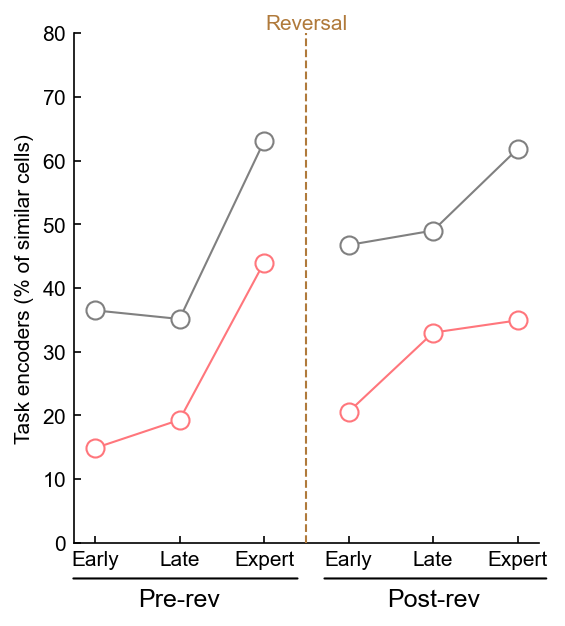

In [21]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_pc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_pc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_pc_task_encoders*100,fc='white',ec=CR_COLOR,s=75)

ax.plot([0,1,2],NCR_pc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_pc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_pc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75)

ax.set_ylim([0,80])
ax.set_ylabel('Task encoders (% of similar cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -10.643725039186364/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -10.643725039186364/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Task encoders similar cells over learning with danimals.png'),transparent=False,facecolor="white")

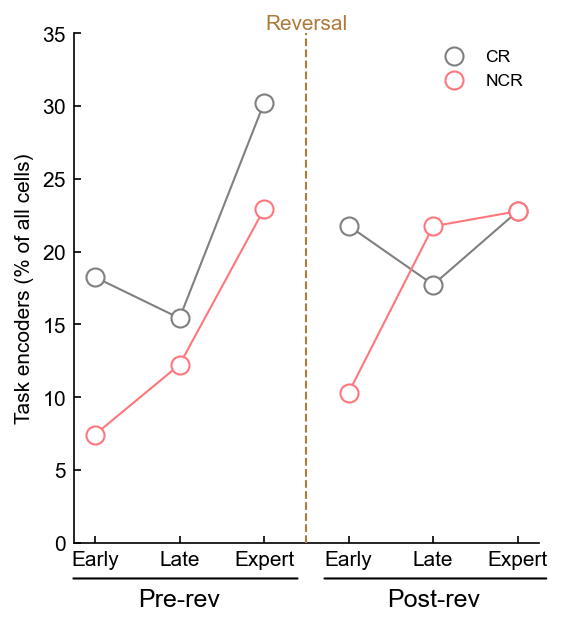

In [23]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=75,label='CR')

ax.plot([0,1,2],NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75,label='NCR')

ax.set_ylim([0,35])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -4.656629704644034/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -4.656629704644034/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Task encoders all cells over learning with danimals.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Task encoders all cells over learning with danimals.png'),transparent=False,facecolor="white")

# CR/NCR task encoders -- ramping classifications

In [24]:
ramping_baseline_median = np.nanmedian(ramping_preearly)

NCR_pc_task_encoders = np.array([np.nan]*6)
CR_pc_task_encoders = np.array([np.nan]*6)
NCR_allpc_task_encoders = np.array([np.nan]*6)
CR_allpc_task_encoders = np.array([np.nan]*6)

phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for phase_idx,phase in enumerate(phases):
    
    CR_te_in_phase = 0
    CR_cells_in_phase = 0
    NCR_te_in_phase = 0
    NCR_cells_in_phase = 0
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
            continue
        if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
            continue
        if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue
        if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue

        if EILphases[idx] != phase:
            continue
            
        acc = getDataPoint(stim_25s_df,session,clust,'stimulus','accuracy')
        #acc = getOldDataPoint(old_dec_df,session,clust,'accuracies')
        
        if np.isnan(acc):
            pass#continue
        
        #Require >= 100 trials
        conditions = ilep.getAllConditions(sessionfile,clust)
        if len(conditions['all_trials'].trials) < 100:
            pass#continue
            
        this_rampingmod = sessionfile.responsiveness[clust]['all_trials'].rampingMod
        if this_rampingmod < ramping_baseline_median:
            if is_TE[idx]:
                NCR_te_in_phase += 1
            NCR_cells_in_phase += 1
        elif this_rampingmod >= ramping_baseline_median:
            if is_TE[idx]:
                CR_te_in_phase += 1
            CR_cells_in_phase += 1
            
        cells_in_phase += 1
        if is_TE[idx]:
            te_in_phase += 1
    
    CR_pc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase))
    NCR_pc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase))
    
    CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
    NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))

1440it [00:13, 107.60it/s]
1440it [00:14, 99.39it/s] 
1440it [00:12, 114.73it/s]
1440it [00:18, 76.21it/s] 
1440it [00:17, 83.07it/s] 
1440it [00:15, 94.98it/s] 


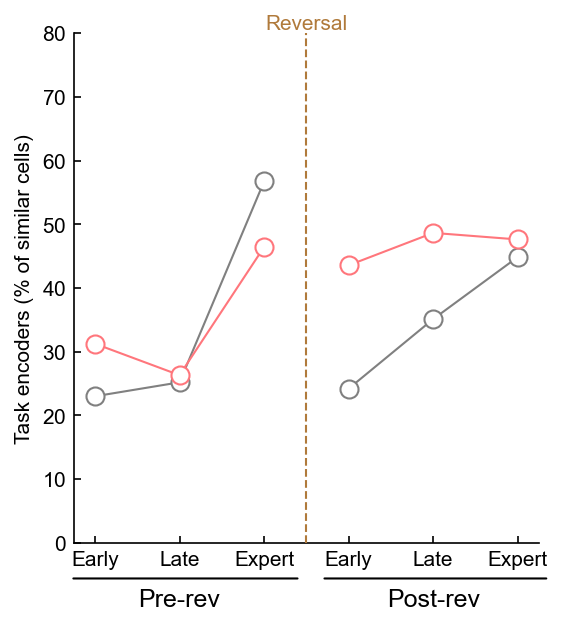

In [30]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_pc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_pc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_pc_task_encoders*100,fc='white',ec=CR_COLOR,s=75)

ax.plot([0,1,2],NCR_pc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_pc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_pc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75)

ax.set_ylim([0,80])
ax.set_ylabel('Task encoders (% of similar cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -10.643725039186364/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -10.643725039186364/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Task encoders similar cells  ramping classified over learning with danimals.png'),transparent=False,facecolor="white")

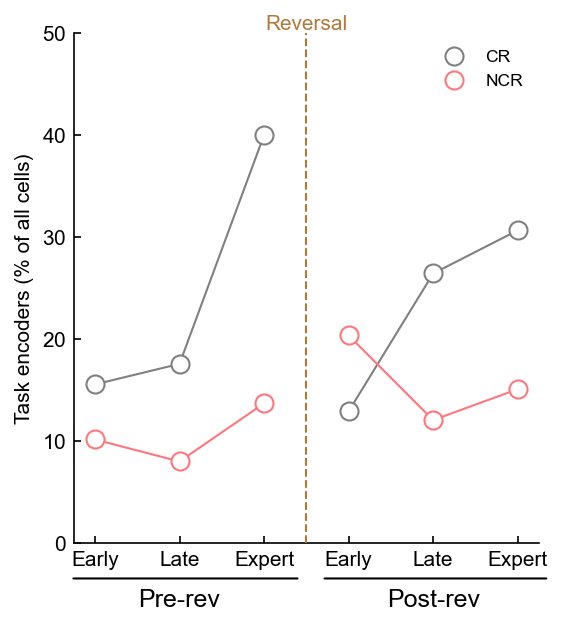

In [31]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=75,label='CR')

ax.plot([0,1,2],NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75,label='NCR')

#ax.set_ylim([0,35])
ax.set_ylim([0,50])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -4.434885432994318, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -4.434885432994318, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Task encoders all cells ramping classified over learning with danimals.png'),transparent=False,facecolor="white")

# Shift in responsiveness -- TEs

In [26]:
pctCR_task_encoders = CR_allpc_task_encoders / (NCR_allpc_task_encoders + CR_allpc_task_encoders)
pctCR_task_encoders = 100*pctCR_task_encoders

In [27]:
print(pctCR_task_encoders)

[71.05263158 54.16666667 56.8627451  68.10344828 43.47826087 51.64835165]


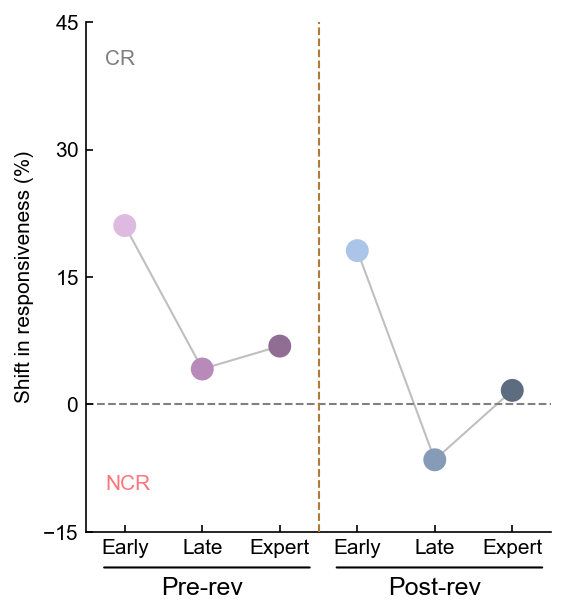

In [28]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
percentCR = pctCR_task_encoders
labels = ['Early','Late','Expert','Early','Late','Expert']
#percentCR = np.array([FRmod_prelate_pc,FRmod_postearly_pc,FRmod_postint_pc,FRmod_postlate_pc])*100
#labels = ['Pre Late','Early','Intermediate\npost-reversal','Late']
numCon = len(labels)
ax.plot([0,1,2],(percentCR[0:3]-50),color='grey',lw=1,alpha=0.5)
ax.plot([3,4,5],(percentCR[3:6]-50),color='grey',lw=1,alpha=0.5)

color=NCR_CR_cmap((percentCR-40)/20)
#ax.scatter(range(numCon),(percentCR-50),c=color,s=100,zorder=10)
ax.scatter(range(numCon),(percentCR-50),c=PHASE_COLORS,s=100,zorder=10)



xlims = [-0.5,numCon-0.5]
ax.plot(xlims,[0,0],c='grey',linestyle='--',lw=1,zorder=-10)
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)



ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-15,45])
ax.set_yticks([-15,0,15,30,45])
ax.text(-0.25,40,'CR',color=CR_COLOR)
ax.text(-0.25,-10,'NCR',color=NCR_COLOR)


ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)


#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -20.321862519593182, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -20.321862519593182, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Shift in responsiveness task encoders over learning with danimals.png'),transparent=False,facecolor="white")

In [20]:
np.unique(choice_df['accuracy'])

array([0.45171429, 0.55329487, 0.58660714, 0.60298182, 0.61298419,
       0.6255    , 0.63216484, 0.63778431, 0.64371675, 0.67081818,
       0.68787879, 0.69084076, 0.69134783, 0.69635556, 0.69834545,
       0.70252564, 0.70583333, 0.72958242, 0.73016667, 0.74688372,
       0.75822727, 0.76714286, 0.77013333, 0.77328105, 0.77371739,
       0.77524421, 0.78446154, 0.7866    , 0.78860833, 0.79195333,
       0.8015922 , 0.80465608, 0.80636998, 0.81412381, 0.84778275,
       0.84966462, 0.8568253 , 0.85812319, 0.86426667, 0.86533333,
       0.86719   , 0.87653654, 0.88191775, 0.88592308, 0.88705526,
       0.89133333, 0.89454127, 0.89718895, 0.9022    , 0.91577619,
       0.92136   , 0.95283659,        nan])

# Task encoders -- choice

Median  of TEs is 0.6156115601547079
Percent of TEs is 0.19444444444444445
Number  of TEs is 280


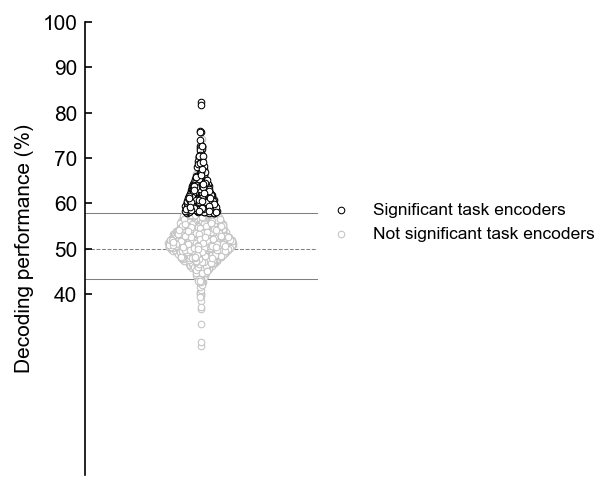

In [34]:
fig, ax = plt.subplots(figsize=(4,4))

X = np.ones_like(choice_acc)
_,Y = ilep.violin(X,choice_acc)
X,_ = ilep.violin(X,np.log10(choice_acc),width=0.35)

is_TE = is_TE_c
size=10
ax.scatter(X[is_TE], Y[is_TE], s=size, ec='black', fc='white', lw=0.5,zorder=0,label='Significant task encoders')
ax.scatter(X[np.logical_not(is_TE)], Y[np.logical_not(is_TE)], s=size, ec='#C3C3C3', fc='white', lw=0.5,zorder=-1,label='Not significant task encoders')

ax.set_xlim([0.5,2.5])
ax.set_xticks([])

ax.set_ylim([0.0,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])

ax.axhline(task_encoder_threshold_c,linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
ax.axhline(0.5,linestyle='--',color='grey',zorder=-10,lw=0.5,xmax=0.5)
ax.axhline(0.5-(task_encoder_threshold_s-0.5),linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
#ax.axhline(np.median(stim_acc[is_TE_s]),xmax=0.5,color='green')

print(f"Median  of TEs is {np.median(choice_acc[is_TE_c])}")
print(f"Percent of TEs is {np.mean(is_TE_c)}")
print(f"Number  of TEs is {np.sum(is_TE_c)}")

ax.legend(frameon=False,loc=(0.5,0.5))

ax.set_ylabel('Decoding performance (%)')
ax.spines['bottom'].set_visible(False)

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Task encoders choice schematic weighted.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Task encoders choice schematic weighted.png'),transparent=False,facecolor="white")

In [35]:
print(f"Nanpercent of TEs is {np.sum(is_TE_c) / np.sum(np.isfinite(choice_acc))}")

Nanpercent of TEs is 0.21621621621621623


In [36]:
pc_task_encoders = np.array([np.nan]*6)
total_phases = ['pre early','pre late','pre expert','post early','post late','post expert']
labels = ['Early','Late','Expert','Early','Late','Expert']
for phase_idx,phase in enumerate(total_phases):
    
    te_in_phase = 0
    cells_in_phase = 0
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
            continue
        if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
            continue
        if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue
        if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue

        if EILphases[idx] != phase:
            continue
            
        acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
        #acc = getOldDataPoint(old_dec_df,session,clust,'accuracies')
        
        if np.isnan(acc):
            pass#continue
        
        #Require >= 100 trials
        conditions = ilep.getAllConditions(sessionfile,clust)
        if len(conditions['all_trials'].trials) < 100:
            pass#continue
            
        cells_in_phase += 1
        if is_TE[idx]:
            te_in_phase += 1
            
    print(f"n={te_in_phase}/{cells_in_phase}")
    
    pc_task_encoders[phase_idx] = np.sum(te_in_phase) / np.sum(cells_in_phase)

1440it [00:13, 110.68it/s]
18it [00:00, 169.77it/s]

n=33/148


1440it [00:14, 100.15it/s]
4it [00:00, 36.36it/s]

n=40/188


1440it [00:12, 115.43it/s]
17it [00:00, 107.57it/s]

n=14/117


1440it [00:18, 76.87it/s] 
17it [00:00, 155.93it/s]

n=80/349


1440it [00:17, 83.33it/s] 
18it [00:00, 176.43it/s]

n=34/299


1440it [00:14, 96.59it/s] 

n=42/213


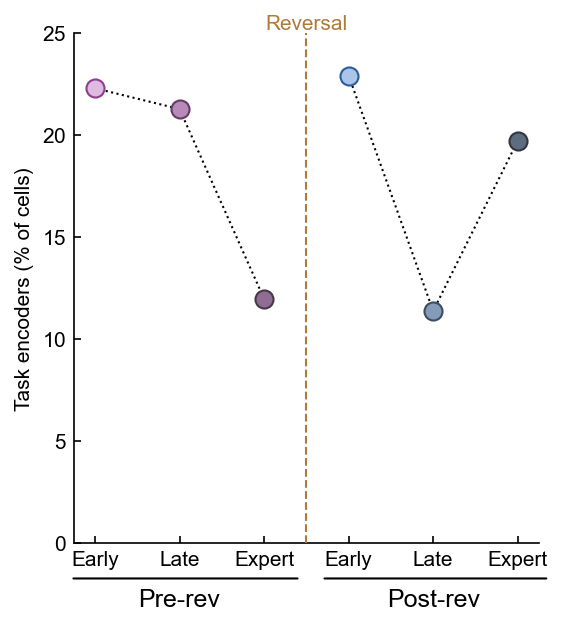

In [37]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
chosen_color='k'
ax.plot([0,1,2],pc_task_encoders[0:3]*100,color='k',linestyle=':',lw=1,alpha=1,zorder=-10)
ax.plot([3,4,5],pc_task_encoders[3:6]*100,color='k',linestyle=':',lw=1,alpha=1,zorder=-10)
#ax.scatter([0,1,2,3,4,5],pc_task_encoders*100,fc='white',ec=PHASE_COLORS,s=75)
for idx,pct in enumerate(pc_task_encoders):
    eye_color=PHASE_COLORS[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)

    summary_size=50
    summary_width=1
    
    ax.scatter(idx,pct*100,fc=eye_color,ec=border_color,s=75)
#ax.scatter([3,4,5],pc_task_encoders[3:6]*100,fc='white',ec=chosen_color,s=75)

ax.set_ylim([0,25])
ax.set_ylabel('Task encoders (% of cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#Wide mode
# ax.annotate('', xy=(0.0, -0.105), xycoords='axes fraction', xytext=(0.465, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.545, -0.105), xycoords='axes fraction', xytext=(1.0125, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# ax.text(xtick_pos_pre, -7.982793779389773, 'Pre-rev', ha='center', va='top', fontsize=12)
# ax.text(xtick_pos_post, -7.982793779389773, 'Post-rev', ha='center', va='top',  fontsize=12)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -2.217442716497159, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -2.217442716497159, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases inference buffer task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases old decoding task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 2 inference buffer task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 2  old decoding task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 3 inference buffer task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 3 inference buffer task encoders.png'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 3  old decoding task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 3  old decoding task encoders.png'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Experimentalist phases inference buffer task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Experimentalist phases old decoding task encoders.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 3 inference buffer task encoders 100 trials or greater.png'),transparent=False,facecolor="white")

#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 4 all trials.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 4 active trials.png'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Automated phases 4 active trials danimals.png'),transparent=False,facecolor="white")

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Choice task encoders over learning weighted.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Choice task encoders over learning weighted.png'),transparent=False,facecolor="white")

In [32]:
-7.982793779389773 * (70/60)

-9.313259409288069

In [33]:
-9.313259409288069/1.5# + 40

-6.208839606192046

In [25]:
-6.208839606192046 * 25 / 70

-2.217442716497159

# CR/NCR task encoders -- Choice

In [38]:
FRmod_baseline_median = np.nanmedian(FRmod_preearly)

NCR_pc_task_encoders = np.array([np.nan]*6)
CR_pc_task_encoders = np.array([np.nan]*6)
NCR_allpc_task_encoders = np.array([np.nan]*6)
CR_allpc_task_encoders = np.array([np.nan]*6)

phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for phase_idx,phase in enumerate(phases):
    
    CR_te_in_phase = 0
    CR_cells_in_phase = 0
    NCR_te_in_phase = 0
    NCR_cells_in_phase = 0
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
            continue
        if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
            continue
        if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue
        if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue

        if EILphases[idx] != phase:
            continue
            
        acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
        
        if np.isnan(acc):
            pass#continue
        
        #Require >= 100 trials
        conditions = ilep.getAllConditions(sessionfile,clust)
        if len(conditions['all_trials'].trials) < 100:
            pass#continue
            
        this_FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        if this_FRmod < FRmod_baseline_median:
            if is_TE[idx]:
                NCR_te_in_phase += 1
            NCR_cells_in_phase += 1
        elif this_FRmod >= FRmod_baseline_median:
            if is_TE[idx]:
                CR_te_in_phase += 1
            CR_cells_in_phase += 1
            
        cells_in_phase += 1
        if is_TE[idx]:
            te_in_phase += 1
    
    CR_pc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase))
    NCR_pc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase))
    
    CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
    NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))

1440it [00:13, 107.64it/s]
1440it [00:14, 98.49it/s] 
1440it [00:12, 114.39it/s]
1440it [00:18, 77.20it/s] 
1440it [00:17, 83.57it/s] 
1440it [00:15, 95.88it/s] 


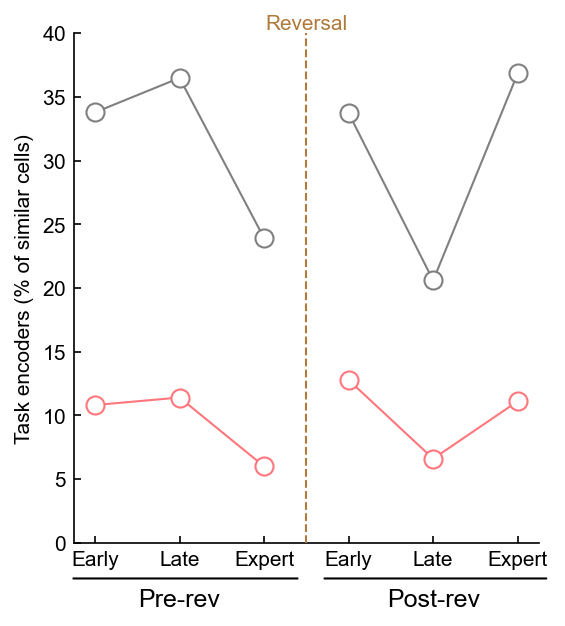

In [30]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_pc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_pc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_pc_task_encoders*100,fc='white',ec=CR_COLOR,s=75)

ax.plot([0,1,2],NCR_pc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_pc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_pc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75)

ax.set_ylim([0,40])
ax.set_ylabel('Task encoders (% of similar cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -5.321862519593182/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -5.321862519593182/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR weighted Choice Task encoders similar cells over learning.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR weighted Choice Task encoders similar cells over learning.png'),transparent=False,facecolor="white")

In [29]:
-10.643725039186364 * 40 / 80

-5.321862519593182

Unweighted

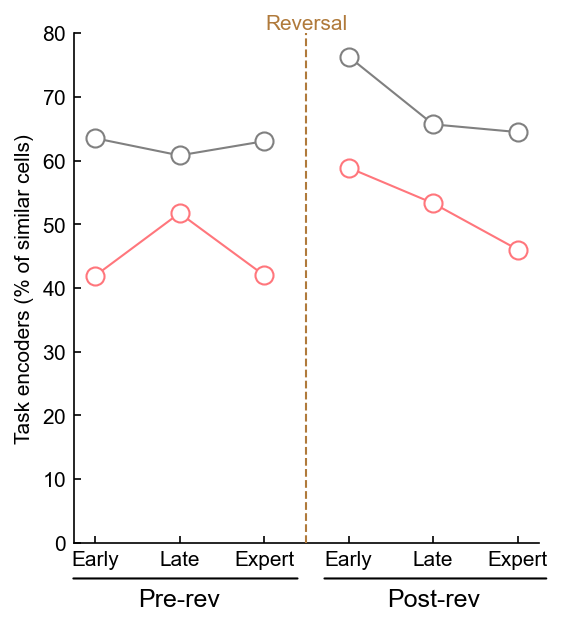

In [40]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_pc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_pc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_pc_task_encoders*100,fc='white',ec=CR_COLOR,s=75)

ax.plot([0,1,2],NCR_pc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_pc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_pc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75)

ax.set_ylim([0,80])
ax.set_ylabel('Task encoders (% of similar cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -10.643725039186364/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -10.643725039186364/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

#plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Choice Task encoders similar cells over learning.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Choice Task encoders similar cells over learning.png'),transparent=False,facecolor="white")

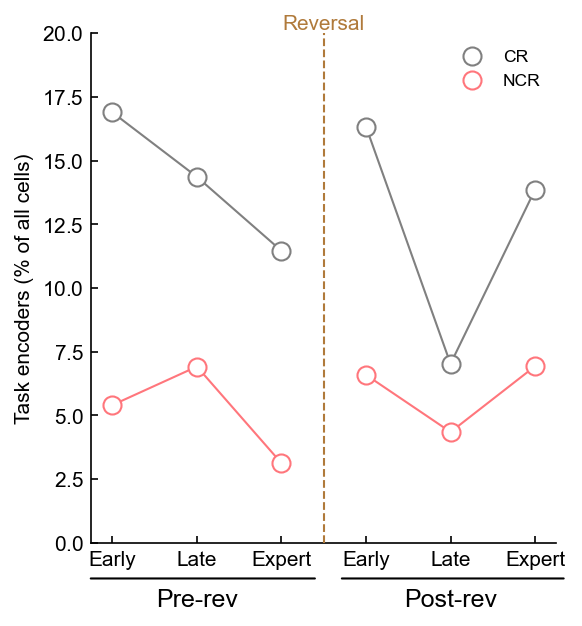

In [33]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=75,label='CR')

ax.plot([0,1,2],NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75,label='NCR')

ax.set_ylim([0,20])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -2.6609312597965915/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -2.6609312597965915/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR weighted Choice Task encoders all cells over learning.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR weighted Choice Task encoders all cells over learning.png'),transparent=False,facecolor="white")

In [32]:
-6.652328149491478 * 20 / 50

-2.6609312597965915

Unweighted

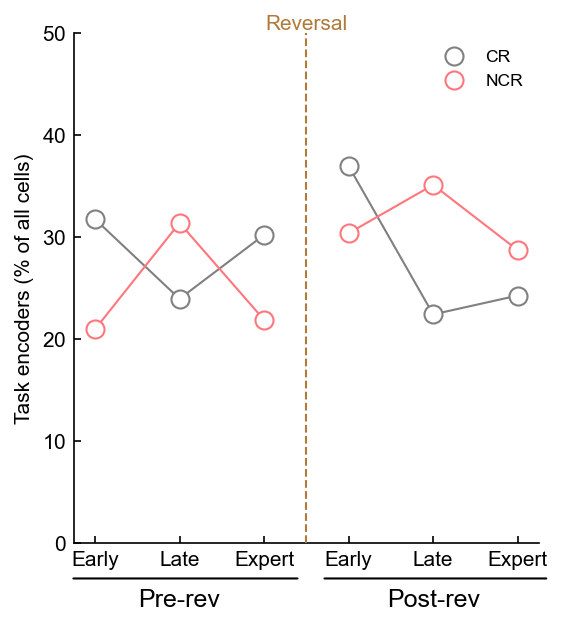

In [41]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=75,label='CR')

ax.plot([0,1,2],NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75,label='NCR')

ax.set_ylim([0,50])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -6.652328149491478/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -6.652328149491478/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Choice Task encoders all cells over learning.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Choice Task encoders all cells over learning.png'),transparent=False,facecolor="white")

# CR/NCR task encoders -- Choice -- ramping classified

In [34]:
FRmod_baseline_median = np.nanmedian(ramping_preearly)

NCR_pc_task_encoders = np.array([np.nan]*6)
CR_pc_task_encoders = np.array([np.nan]*6)
NCR_allpc_task_encoders = np.array([np.nan]*6)
CR_allpc_task_encoders = np.array([np.nan]*6)

phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for phase_idx,phase in enumerate(phases):
    
    CR_te_in_phase = 0
    CR_cells_in_phase = 0
    NCR_te_in_phase = 0
    NCR_cells_in_phase = 0
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
            continue
        if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
            continue
        if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue
        if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue

        if EILphases[idx] != phase:
            continue
            
        acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
        
        if np.isnan(acc):
            pass#continue
        
        #Require >= 100 trials
        conditions = ilep.getAllConditions(sessionfile,clust)
        if len(conditions['all_trials'].trials) < 100:
            pass#continue
            
        this_rampMod = sessionfile.responsiveness[clust]['all_trials'].rampingMod
        if this_rampMod < FRmod_baseline_median:
            if is_TE[idx]:
                NCR_te_in_phase += 1
            NCR_cells_in_phase += 1
        elif this_rampMod >= FRmod_baseline_median:
            if is_TE[idx]:
                CR_te_in_phase += 1
            CR_cells_in_phase += 1
            
        cells_in_phase += 1
        if is_TE[idx]:
            te_in_phase += 1
    
    CR_pc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase))
    NCR_pc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase))
    
    CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
    NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))

1440it [00:13, 105.91it/s]
1440it [00:14, 96.99it/s] 
1440it [00:12, 114.32it/s]
1440it [00:18, 76.60it/s] 
1440it [00:17, 84.36it/s] 
1440it [00:14, 97.86it/s] 


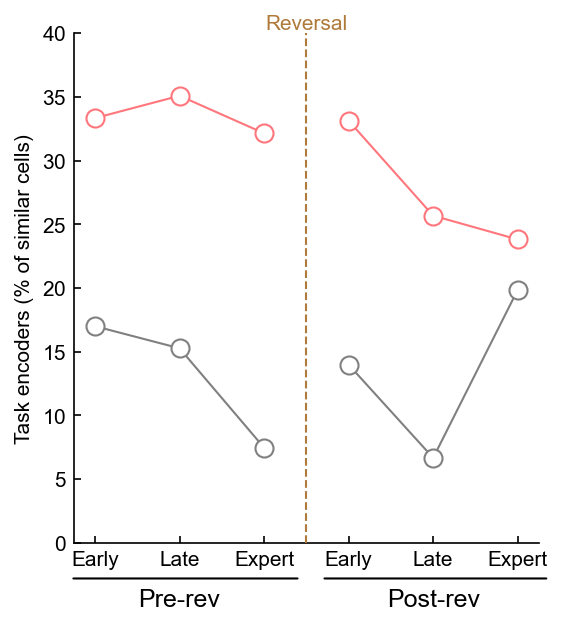

In [38]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_pc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_pc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_pc_task_encoders*100,fc='white',ec=CR_COLOR,s=75)

ax.plot([0,1,2],NCR_pc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_pc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_pc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75)

ax.set_ylim([0,40])
ax.set_ylabel('Task encoders (% of similar cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -5.321862519593182/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -5.321862519593182/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR weighted Choice Task encoders similar cells ramping classified over learning.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR weighted Choice Task encoders similar cells ramping classified over learning.png'),transparent=False,facecolor="white")

In [36]:
-10.643725039186364 * 40 / 80

-5.321862519593182

Unweighted

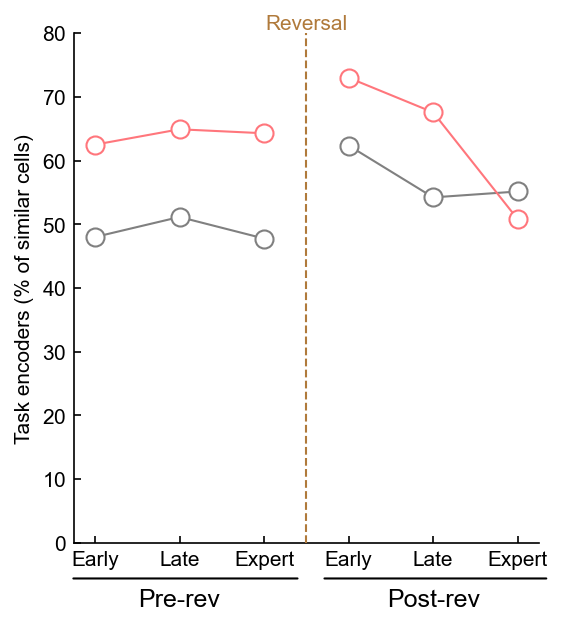

In [37]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_pc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_pc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_pc_task_encoders*100,fc='white',ec=CR_COLOR,s=75)

ax.plot([0,1,2],NCR_pc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_pc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_pc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75)

ax.set_ylim([0,80])
ax.set_ylabel('Task encoders (% of similar cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -10.643725039186364/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -10.643725039186364/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

#plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Choice Task encoders similar cells ramping classified over learning.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Choice Task encoders similar cells ramping classified over learning.png'),transparent=False,facecolor="white")

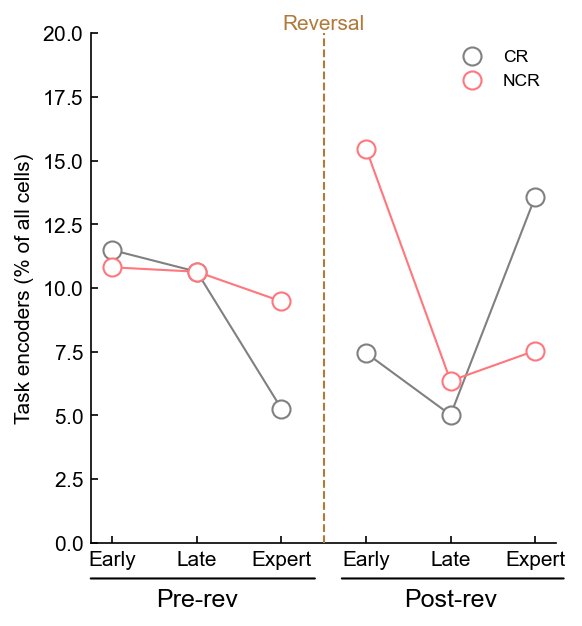

In [41]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=75,label='CR')

ax.plot([0,1,2],NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75,label='NCR')

ax.set_ylim([0,20])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -2.6609312597965915/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -2.6609312597965915/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR weighted Choice Task encoders all cells ramping classified over learning.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR weighted Choice Task encoders all cells ramping classified over learning.png'),transparent=False,facecolor="white")

In [40]:
-6.652328149491478 * 20 / 50

-2.6609312597965915

Unweighted

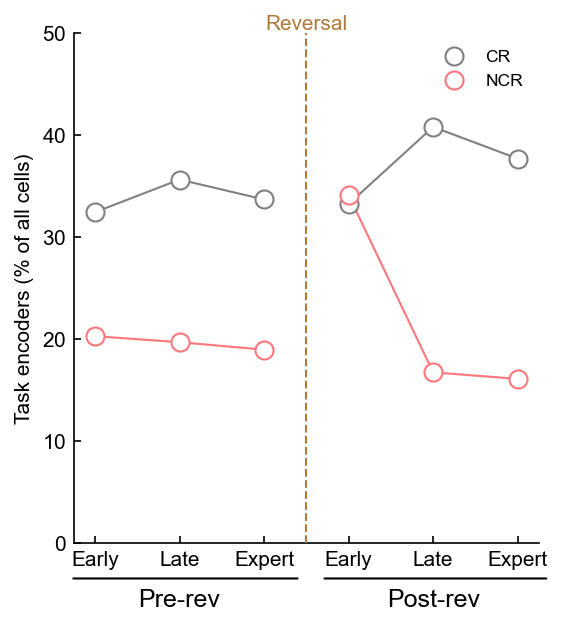

In [38]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=75,label='CR')

ax.plot([0,1,2],NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75,label='NCR')

ax.set_ylim([0,50])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -6.652328149491478/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -6.652328149491478/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Choice Task encoders all cells ramping classified over learning.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','CR-NCR Choice Task encoders all cells ramping classified over learning.png'),transparent=False,facecolor="white")

In [71]:
sessionfile.responsiveness[clust]['all_trials']

namespace(trials=array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
                         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
                        123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
                        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
                        149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
                        162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
                        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
                        188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
                        201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
                        214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
                     

# Task Encoders Stats -- Split by session

In [37]:
FRmod_baseline_median = np.nanmedian(FRmod_preearly)

pre_early_CR_pctTE = []
pre_early_NCR_pctTE = []
pre_early_ALL_pctTE = []

pre_late_CR_pctTE = []
pre_late_NCR_pctTE = []
pre_late_ALL_pctTE = []

pre_expert_CR_pctTE = []
pre_expert_NCR_pctTE = []
pre_expert_ALL_pctTE = []

post_early_CR_pctTE = []
post_early_NCR_pctTE = []
post_early_ALL_pctTE = []

post_late_CR_pctTE = []
post_late_NCR_pctTE = []
post_late_ALL_pctTE = []

post_expert_CR_pctTE = []
post_expert_NCR_pctTE = []
post_expert_ALL_pctTE = []

last_session = None
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    if session == last_session:
        continue
    sessionfile = ilep.loadSessionCached(act_directory,session)
    last_session = session
    
    if sessionfile.meta.region != 'AC':
        continue
        continue
        
    this_session_accuracies = []
    this_session_pval_c = []
    this_session_pval_s = []
    this_session_FRmods = []
    for clust in sessionfile.clusters.good:
        stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','accuracy')
        pval_c = getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
        pval_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
        this_session_accuracies.append(stim_accuracy)
        this_session_pval_c.append(pval_c)
        this_session_pval_s.append(pval_s)
        this_session_FRmods.append(FRmod)
        
    this_session_accuracies = np.array(this_session_accuracies)
    this_session_pval_c = np.array(this_session_pval_c)
    this_session_pval_s = np.array(this_session_pval_s)
    this_session_FRmods = np.array(this_session_FRmods)
        
    #Determine task encoders
    this_session_is_finite_s = np.isfinite(this_session_accuracies)
    this_session_is_valid_pval_c = np.less(this_session_pval_c,0.05)
    this_session_is_valid_pval_s = np.less(this_session_pval_s,0.05)
    this_session_is_TE = np.greater_equal(this_session_accuracies,task_encoder_threshold_s)
    this_session_is_TE = np.logical_and(this_session_is_TE,this_session_is_finite_s)
    this_session_is_TE = np.logical_and(this_session_is_TE,this_session_is_valid_pval_c)
    this_session_is_TE = np.logical_and(this_session_is_TE,this_session_is_valid_pval_s)
        
    #Determine CR/NCR
    this_session_CR = np.greater_equal(this_session_FRmods,FRmod_baseline_median)
    this_session_NCR = np.less(this_session_FRmods,FRmod_baseline_median)
        
    this_session_pct_TE = np.sum(this_session_is_TE) / len(this_session_is_TE)
    this_session_pct_CR = np.sum(np.logical_and(this_session_is_TE,this_session_CR)) / len(this_session_is_TE)
    this_session_pct_NCR = np.sum(np.logical_and(this_session_is_TE,this_session_NCR)) / len(this_session_is_TE)
        
    if EILphases[idx] == 'pre early':
        pre_early_CR_pctTE.append(this_session_pct_TE)
        pre_early_NCR_pctTE.append(this_session_pct_CR)
        pre_early_ALL_pctTE.append(this_session_pct_NCR)
    if EILphases[idx] == 'pre late':
        pre_late_CR_pctTE.append(this_session_pct_TE)
        pre_late_NCR_pctTE.append(this_session_pct_CR)
        pre_late_ALL_pctTE.append(this_session_pct_NCR)
    if EILphases[idx] == 'pre expert':
        pre_expert_CR_pctTE.append(this_session_pct_TE)
        pre_expert_NCR_pctTE.append(this_session_pct_CR)
        pre_expert_ALL_pctTE.append(this_session_pct_NCR)
    if EILphases[idx] == 'post early':
        post_early_CR_pctTE.append(this_session_pct_TE)
        post_early_NCR_pctTE.append(this_session_pct_CR)
        post_early_ALL_pctTE.append(this_session_pct_NCR)
    if EILphases[idx] == 'post late':
        post_late_CR_pctTE.append(this_session_pct_TE)
        post_late_NCR_pctTE.append(this_session_pct_CR)
        post_late_ALL_pctTE.append(this_session_pct_NCR)
    if EILphases[idx] == 'post expert':
        post_expert_CR_pctTE.append(this_session_pct_TE)
        post_expert_NCR_pctTE.append(this_session_pct_CR)
        post_expert_ALL_pctTE.append(this_session_pct_NCR)

pre_early_CR_pctTE = np.array(pre_early_CR_pctTE)
pre_early_NCR_pctCR = np.array(pre_early_NCR_pctTE)
pre_early_ALL_pctNCR = np.array(pre_early_ALL_pctTE)

pre_late_CR_pctTE = np.array(pre_late_CR_pctTE)
pre_late_NCR_pctCR = np.array(pre_late_NCR_pctTE)
pre_late_ALL_pctNCR = np.array(pre_late_ALL_pctTE)

pre_expert_CR_pctTE = np.array(pre_expert_CR_pctTE)
pre_expert_NCR_pctCR = np.array(pre_expert_NCR_pctTE)
pre_expert_ALL_pctNCR = np.array(pre_expert_ALL_pctTE)

post_early_CR_pctTE = np.array(post_early_CR_pctTE)
post_early_NCR_pctCR = np.array(post_early_NCR_pctTE)
post_early_ALL_pctNCR = np.array(post_early_ALL_pctTE)

post_late_CR_pctTE = np.array(post_late_CR_pctTE)
post_late_NCR_pctCR = np.array(post_late_NCR_pctTE)
post_late_ALL_pctNCR = np.array(post_late_ALL_pctTE)

post_expert_CR_pctTE = np.array(post_expert_CR_pctTE)
post_expert_NCR_pctCR = np.array(post_expert_NCR_pctTE)
post_expert_ALL_pctNCR = np.array(post_expert_ALL_pctTE)

2110it [00:07, 265.26it/s]


In [47]:
data_TE_ALL = SimpleNamespace()
data_TE_ALL.preearly = pre_early_ALL_pctTE
data_TE_ALL.prelate = pre_late_ALL_pctTE
data_TE_ALL.preexpert = pre_expert_ALL_pctTE
data_TE_ALL.postearly = post_early_ALL_pctTE
data_TE_ALL.postlate = post_late_ALL_pctTE
data_TE_ALL.postexpert = post_expert_ALL_pctTE
ilep.nonparametricIndependentStatsCompareToPreearly(data_TE_ALL)
pass

            Source        SS     DF        MS         F     p-unc       np2
0            phase  0.174718    4.0  0.043679  1.799729  0.131703  0.044937
1          context  0.127543    1.0  0.127543  5.255193  0.023244  0.033207
2  phase * context  0.040391    4.0  0.010098  0.416062  0.796877  0.010760
3         Residual  3.713308  153.0  0.024270       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.514553  0.643192 -0.299669
12  post-expert  baseline  experimental  0.297902  0.496504 -0.626318
13    post-late  baseline  experimental  0.256595  0.496504 -0.520447
14   pre-expert  baseline  experimental  0.270185  0.496504 -0.687045
15     pre-late  baseline  experimental  1.000000  1.000000 -0.153707


In [48]:
data_TE_CR = SimpleNamespace()
data_TE_CR.preearly = pre_early_CR_pctTE
data_TE_CR.prelate = pre_late_CR_pctTE
data_TE_CR.preexpert = pre_expert_CR_pctTE
data_TE_CR.postearly = post_early_CR_pctTE
data_TE_CR.postlate = post_late_CR_pctTE
data_TE_CR.postexpert = post_expert_CR_pctTE
ilep.nonparametricIndependentStatsCompareToPreearly(data_TE_CR)
pass

            Source        SS     DF        MS         F     p-unc       np2
0            phase  0.928341    4.0  0.232085  3.807212  0.005578  0.090525
1          context  0.164713    1.0  0.164713  2.702014  0.102275  0.017354
2  phase * context  0.313060    4.0  0.078265  1.283888  0.278781  0.032476
3         Residual  9.326780  153.0  0.060959       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.937803  0.937803  0.083262
12  post-expert  baseline  experimental  0.201045  0.502612 -0.541384
13    post-late  baseline  experimental  0.443517  0.739196 -0.360615
14   pre-expert  baseline  experimental  0.092482  0.462409 -1.004056
15     pre-late  baseline  experimental  0.647361  0.809201  0.293345


In [49]:
data_TE_NCR = SimpleNamespace()
data_TE_NCR.preearly = pre_early_NCR_pctTE
data_TE_NCR.prelate = pre_late_NCR_pctTE
data_TE_NCR.preexpert = pre_expert_NCR_pctTE
data_TE_NCR.postearly = post_early_NCR_pctTE
data_TE_NCR.postlate = post_late_NCR_pctTE
data_TE_NCR.postexpert = post_expert_NCR_pctTE
ilep.nonparametricIndependentStatsCompareToPreearly(data_TE_NCR)
pass

            Source        SS     DF        MS         F     p-unc       np2
0            phase  0.360082    4.0  0.090021  2.032492  0.092583  0.050456
1          context  0.001820    1.0  0.001820  0.041096  0.839622  0.000269
2  phase * context  0.157613    4.0  0.039403  0.889650  0.471714  0.022730
3         Residual  6.776484  153.0  0.044291       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.667111  0.987235  0.296610
12  post-expert  baseline  experimental  0.955411  0.987235 -0.132114
13    post-late  baseline  experimental  0.987235  0.987235  0.028050
14   pre-expert  baseline  experimental  0.302457  0.830731 -0.607757
15     pre-late  baseline  experimental  0.332292  0.830731  0.409442


# Stimulus Task Encoders Stats -- By decoding accuracy distributions

In [20]:
FRmod_baseline_median = np.nanmedian(FRmod_preearly)

Dec_preearly = []
Dec_prelate = []
Dec_preexpert = []
Dec_postearly = []
Dec_postlate = []
Dec_postexpert = []

Dec_CR_preearly = []
Dec_CR_prelate = []
Dec_CR_preexpert = []
Dec_CR_postearly = []
Dec_CR_postlate = []
Dec_CR_postexpert = []

Dec_NCR_preearly = []
Dec_NCR_prelate = []
Dec_NCR_preexpert = []
Dec_NCR_postearly = []
Dec_NCR_postlate = []
Dec_NCR_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    acc = getDataPoint(stim_25s_df,session,clust,'stimulus','accuracy')
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    
    if EILphases[idx] == 'pre early':
        Dec_preearly.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_preearly.append(acc)
        else:
            Dec_NCR_preearly.append(acc)
    elif EILphases[idx] == 'pre late':
        Dec_prelate.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_prelate.append(acc)
        else:
            Dec_NCR_prelate.append(acc)
    elif EILphases[idx] == 'pre expert':
        Dec_preexpert.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_preexpert.append(acc)
        else:
            Dec_NCR_preexpert.append(acc)
    elif EILphases[idx] == 'post early':
        Dec_postearly.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_postearly.append(acc)
        else:
            Dec_NCR_postearly.append(acc)
    elif EILphases[idx] == 'post late':
        Dec_postlate.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_postlate.append(acc)
        else:
            Dec_NCR_postlate.append(acc)
    elif EILphases[idx] == 'post expert':
        Dec_postexpert.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_postexpert.append(acc)
        else:
            Dec_NCR_postexpert.append(acc)
        
Dec_preearly = np.array(Dec_preearly)
Dec_prelate = np.array(Dec_prelate)
Dec_preexpert = np.array(Dec_preexpert)
Dec_postearly = np.array(Dec_postearly)
Dec_postlate = np.array(Dec_postlate)
Dec_postexpert = np.array(Dec_postexpert)

Dec_CR_preearly = np.array(Dec_CR_preearly)
Dec_CR_prelate = np.array(Dec_CR_prelate)
Dec_CR_preexpert = np.array(Dec_CR_preexpert)
Dec_CR_postearly = np.array(Dec_CR_postearly)
Dec_CR_postlate = np.array(Dec_CR_postlate)
Dec_CR_postexpert = np.array(Dec_CR_postexpert)

Dec_NCR_preearly = np.array(Dec_NCR_preearly)
Dec_NCR_prelate = np.array(Dec_NCR_prelate)
Dec_NCR_preexpert = np.array(Dec_NCR_preexpert)
Dec_NCR_postearly = np.array(Dec_NCR_postearly)
Dec_NCR_postlate = np.array(Dec_NCR_postlate)
Dec_NCR_postexpert = np.array(Dec_NCR_postexpert)

1440it [00:11, 125.94it/s]


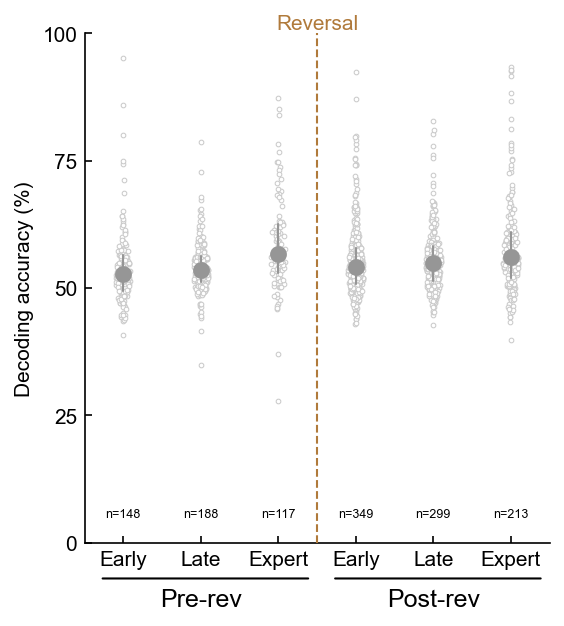

In [18]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Dec_preearly,Dec_prelate,Dec_preexpert,Dec_postearly,Dec_postlate,Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(ramping_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

ax.text(0,0.050,f"n={len(FRmod_preearly)}",fontsize=6,horizontalalignment='center')
ax.text(1,0.050,f"n={len(FRmod_prelate)}",fontsize=6,horizontalalignment='center')
ax.text(2,0.050,f"n={len(FRmod_preexpert)}",fontsize=6,horizontalalignment='center')
ax.text(3,0.050,f"n={len(FRmod_postearly)}",fontsize=6,horizontalalignment='center')
ax.text(4,0.050,f"n={len(FRmod_postlate)}",fontsize=6,horizontalalignment='center')
ax.text(5,0.050,f"n={len(FRmod_postexpert)}",fontsize=6,horizontalalignment='center')

#ax.axhline(task_encoder_threshold_c,linestyle='--',lw=1,zorder=-10,color=GOOD_GREY)

#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Stimulus decoding performance over learning.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Stimulus decoding performance over learning.png'),transparent=False,facecolor="white")

In [21]:
data_dec = SimpleNamespace()
data_dec.preearly = Dec_preearly
data_dec.prelate = Dec_prelate
data_dec.preexpert = Dec_preexpert
data_dec.postearly = Dec_postearly
data_dec.postlate = Dec_postlate
data_dec.postexpert = Dec_postexpert
ilep.nonparametricIndependentStatsCompareToPreearly(data_dec)
pass

            Source         SS      DF        MS          F         p-unc  \
0            phase   0.120957     4.0  0.030239   5.392447  2.571886e-04   
1          context   0.223052     1.0  0.223052  39.776143  3.562429e-10   
2  phase * context   0.108119     4.0  0.027030   4.820102  7.211930e-04   
3         Residual  10.256464  1829.0  0.005608        NaN           NaN   

        np2  
0  0.011656  
1  0.021285  
2  0.010432  
3       NaN  

          phase         A             B         p-unc    p-corr    hedges
11   post-early  baseline  experimental  7.842584e-03  0.009803 -0.206134
12  post-expert  baseline  experimental  1.811115e-06  0.000005 -0.472449
13    post-late  baseline  experimental  2.735541e-04  0.000456 -0.254544
14   pre-expert  baseline  experimental  9.961283e-07  0.000005 -0.565657
15     pre-late  baseline  experimental  4.771839e-02  0.047718 -0.050092


In [56]:
data_dec_CR = SimpleNamespace()
data_dec_CR.preearly = Dec_CR_preearly
data_dec_CR.prelate = Dec_CR_prelate
data_dec_CR.preexpert = Dec_CR_preexpert
data_dec_CR.postearly = Dec_CR_postearly
data_dec_CR.postlate = Dec_CR_postlate
data_dec_CR.postexpert = Dec_CR_postexpert
ilep.nonparametricIndependentStatsCompareToPreearly(data_dec_CR)
pass

            Source        SS      DF        MS          F     p-unc       np2
0            phase  0.162561     4.0  0.040640   4.988272  0.000552  0.019298
1          context  0.190758     1.0  0.190758  23.414067  0.000002  0.022570
2  phase * context  0.148863     4.0  0.037216   4.567946  0.001166  0.017701
3         Residual  8.261223  1014.0  0.008147        NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.020872  0.026090 -0.234707
12  post-expert  baseline  experimental  0.000025  0.000126 -0.605697
13    post-late  baseline  experimental  0.008860  0.014767 -0.225454
14   pre-expert  baseline  experimental  0.000300  0.000750 -0.644918
15     pre-late  baseline  experimental  0.487678  0.487678  0.077996


In [57]:
data_dec_NCR = SimpleNamespace()
data_dec_NCR.preearly = Dec_NCR_preearly
data_dec_NCR.prelate = Dec_NCR_prelate
data_dec_NCR.preexpert = Dec_NCR_preexpert
data_dec_NCR.postearly = Dec_NCR_postearly
data_dec_NCR.postlate = Dec_NCR_postlate
data_dec_NCR.postexpert = Dec_NCR_postexpert
ilep.nonparametricIndependentStatsCompareToPreearly(data_dec_NCR)
pass

            Source        SS      DF        MS          F         p-unc  \
0            phase  0.096318     4.0  0.024080   9.104599  2.946179e-07   
1          context  0.121335     1.0  0.121335  45.877444  1.874254e-11   
2  phase * context  0.033616     4.0  0.008404   3.177603  1.306076e-02   
3         Residual  3.567793  1349.0  0.002645        NaN           NaN   

        np2  
0  0.026287  
1  0.032890  
2  0.009334  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.438832  0.438832 -0.153508
12  post-expert  baseline  experimental  0.000020  0.000101 -0.635348
13    post-late  baseline  experimental  0.001722  0.002870 -0.451470
14   pre-expert  baseline  experimental  0.000396  0.000989 -0.573070
15     pre-late  baseline  experimental  0.020311  0.025388 -0.392264


# Choice Task Encoders Stats -- By decoding accuracy distributions

In [39]:
ramping_baseline_median = np.nanmedian(ramping_preearly)

Dec_preearly = []
Dec_prelate = []
Dec_preexpert = []
Dec_postearly = []
Dec_postlate = []
Dec_postexpert = []

Dec_CR_preearly = []
Dec_CR_prelate = []
Dec_CR_preexpert = []
Dec_CR_postearly = []
Dec_CR_postlate = []
Dec_CR_postexpert = []

Dec_NCR_preearly = []
Dec_NCR_prelate = []
Dec_NCR_preexpert = []
Dec_NCR_postearly = []
Dec_NCR_postlate = []
Dec_NCR_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    ramp = sessionfile.responsiveness[clust]['all_trials'].rampingMod
    
    if EILphases[idx] == 'pre early':
        Dec_preearly.append(acc)
        if ramp >= ramping_baseline_median:
            Dec_CR_preearly.append(acc)
        else:
            Dec_NCR_preearly.append(acc)
    elif EILphases[idx] == 'pre late':
        Dec_prelate.append(acc)
        if ramp >= ramping_baseline_median:
            Dec_CR_prelate.append(acc)
        else:
            Dec_NCR_prelate.append(acc)
    elif EILphases[idx] == 'pre expert':
        Dec_preexpert.append(acc)
        if ramp >= ramping_baseline_median:
            Dec_CR_preexpert.append(acc)
        else:
            Dec_NCR_preexpert.append(acc)
    elif EILphases[idx] == 'post early':
        Dec_postearly.append(acc)
        if ramp >= ramping_baseline_median:
            Dec_CR_postearly.append(acc)
        else:
            Dec_NCR_postearly.append(acc)
    elif EILphases[idx] == 'post late':
        Dec_postlate.append(acc)
        if ramp >= ramping_baseline_median:
            Dec_CR_postlate.append(acc)
        else:
            Dec_NCR_postlate.append(acc)
    elif EILphases[idx] == 'post expert':
        Dec_postexpert.append(acc)
        if ramp >= ramping_baseline_median:
            Dec_CR_postexpert.append(acc)
        else:
            Dec_NCR_postexpert.append(acc)
        
Dec_preearly = np.array(Dec_preearly)
Dec_prelate = np.array(Dec_prelate)
Dec_preexpert = np.array(Dec_preexpert)
Dec_postearly = np.array(Dec_postearly)
Dec_postlate = np.array(Dec_postlate)
Dec_postexpert = np.array(Dec_postexpert)

Dec_CR_preearly = np.array(Dec_CR_preearly)
Dec_CR_prelate = np.array(Dec_CR_prelate)
Dec_CR_preexpert = np.array(Dec_CR_preexpert)
Dec_CR_postearly = np.array(Dec_CR_postearly)
Dec_CR_postlate = np.array(Dec_CR_postlate)
Dec_CR_postexpert = np.array(Dec_CR_postexpert)

Dec_NCR_preearly = np.array(Dec_NCR_preearly)
Dec_NCR_prelate = np.array(Dec_NCR_prelate)
Dec_NCR_preexpert = np.array(Dec_NCR_preexpert)
Dec_NCR_postearly = np.array(Dec_NCR_postearly)
Dec_NCR_postlate = np.array(Dec_NCR_postlate)
Dec_NCR_postexpert = np.array(Dec_NCR_postexpert)

1440it [00:11, 130.12it/s]


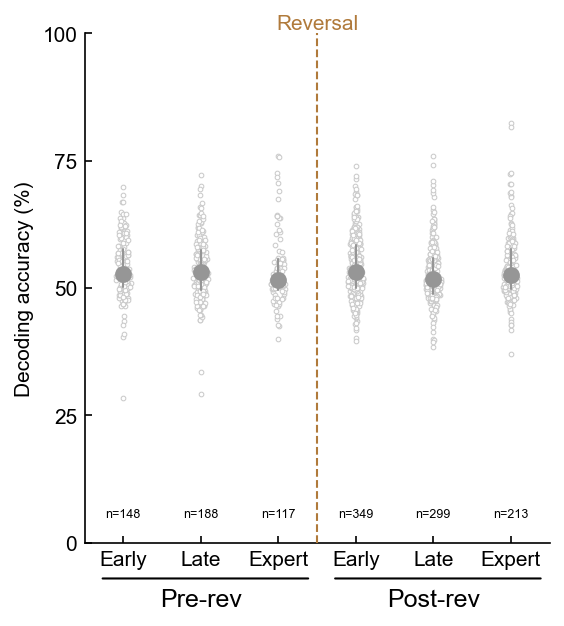

In [41]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Dec_preearly,Dec_prelate,Dec_preexpert,Dec_postearly,Dec_postlate,Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(ramping_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

ax.text(0,0.050,f"n={len(FRmod_preearly)}",fontsize=6,horizontalalignment='center')
ax.text(1,0.050,f"n={len(FRmod_prelate)}",fontsize=6,horizontalalignment='center')
ax.text(2,0.050,f"n={len(FRmod_preexpert)}",fontsize=6,horizontalalignment='center')
ax.text(3,0.050,f"n={len(FRmod_postearly)}",fontsize=6,horizontalalignment='center')
ax.text(4,0.050,f"n={len(FRmod_postlate)}",fontsize=6,horizontalalignment='center')
ax.text(5,0.050,f"n={len(FRmod_postexpert)}",fontsize=6,horizontalalignment='center')

# ax.axhline(task_encoder_threshold_s,linestyle='--',lw=1,zorder=-10,color=GOOD_GREY)

#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Choice weigthed decoding performance over learning.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Choice weighted decoding performance over learning.png'),transparent=False,facecolor="white")

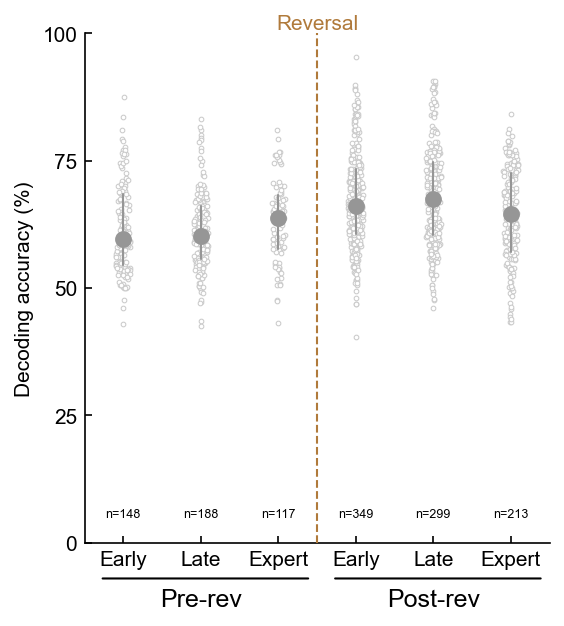

In [34]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Dec_preearly,Dec_prelate,Dec_preexpert,Dec_postearly,Dec_postlate,Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(ramping_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

ax.text(0,0.050,f"n={len(FRmod_preearly)}",fontsize=6,horizontalalignment='center')
ax.text(1,0.050,f"n={len(FRmod_prelate)}",fontsize=6,horizontalalignment='center')
ax.text(2,0.050,f"n={len(FRmod_preexpert)}",fontsize=6,horizontalalignment='center')
ax.text(3,0.050,f"n={len(FRmod_postearly)}",fontsize=6,horizontalalignment='center')
ax.text(4,0.050,f"n={len(FRmod_postlate)}",fontsize=6,horizontalalignment='center')
ax.text(5,0.050,f"n={len(FRmod_postexpert)}",fontsize=6,horizontalalignment='center')

# ax.axhline(task_encoder_threshold_s,linestyle='--',lw=1,zorder=-10,color=GOOD_GREY)

#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Choice decoding performance over learning.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Choice decoding performance over learning.png'),transparent=False,facecolor="white")

In [42]:
data = SimpleNamespace(prereversal_early=Dec_preearly,
                       prereversal_late=Dec_prelate,
                       prereversal_expert=Dec_preexpert,
                       postreversal_early=Dec_postearly,
                       postreversal_late=Dec_postlate,
                       postreversal_expert=Dec_postexpert
                       )

In [43]:
data_dec = SimpleNamespace()
data_dec.preearly = Dec_preearly
data_dec.prelate = Dec_prelate
data_dec.preexpert = Dec_preexpert
data_dec.postearly = Dec_postearly
data_dec.postlate = Dec_postlate
data_dec.postexpert = Dec_postexpert
ilep.nonparametricIndependentStatsCompareToPreearly(data_dec)
pass

            Source        SS      DF        MS         F     p-unc       np2
0            phase  0.019124     4.0  0.004781  1.234950  0.293970  0.002860
1          context  0.006815     1.0  0.006815  1.760203  0.184775  0.001021
2  phase * context  0.010208     4.0  0.002552  0.659202  0.620403  0.001529
3         Residual  6.666637  1722.0  0.003871       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.757334  0.757334 -0.008268
12  post-expert  baseline  experimental  0.393646  0.505561  0.007448
13    post-late  baseline  experimental  0.010062  0.050310  0.216506
14   pre-expert  baseline  experimental  0.167353  0.418382  0.044672
15     pre-late  baseline  experimental  0.404448  0.505561  0.068000


# Stimulus / Choice correlation

In [44]:
stim_acc = []
choice_acc = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    stim_acc.append(stim_accuracy)
    choice_acc.append(choice_accuracy)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)

1440it [00:02, 510.93it/s]


wilcoxon p-value = 1.697518497582244e-14
Mann-whitney p-value = 3.830210808489764e-12


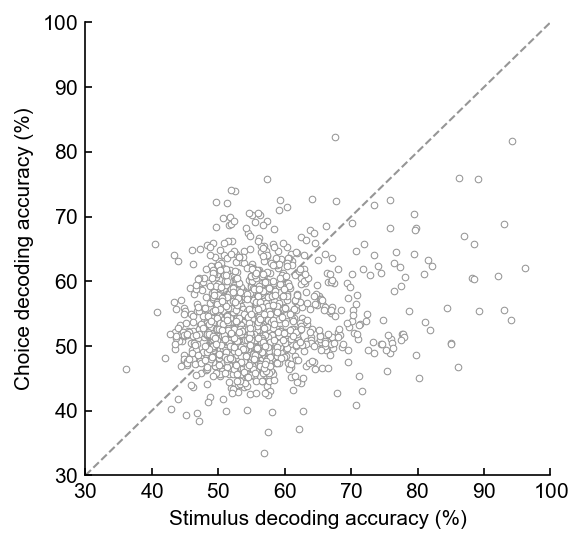

In [45]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(stim_acc*100,choice_acc*100,s=10,fc='white',ec=GOOD_GREY,lw=0.5)
ax.plot([30,100],[30,100],linestyle='--',lw=1,color=GOOD_GREY,zorder=-10)

ax.set_xlim([30,100])
ax.set_ylim([30,100])

ax.set_xlabel('Stimulus decoding accuracy (%)')
ax.set_ylabel('Choice decoding accuracy (%)')

stim,choice = ilep.paired_rmnan(stim_acc,choice_acc)
pval_w = wilcoxon(stim,choice).pvalue
pval_m = mannwhitneyu(stim,choice).pvalue
print(f"wilcoxon p-value = {pval_w}")
print(f"Mann-whitney p-value = {pval_m}")

plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','stimulus vs weighted choice decoding.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','stimulus vs weighted choice decoding.png'),transparent=False,facecolor="white")

In [19]:
dec_1 = []
dec_2 = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    dec_1.append(getDataPoint(dec_df,session,clust,'stimulus','accuracy'))
    dec_2.append(getOldDataPoint(old_dec_df,session,clust,'accuracies'))
    
dec_1 = np.array(dec_1)
dec_2 = np.array(dec_2)

1440it [00:02, 567.49it/s]


(40.0, 100.0)

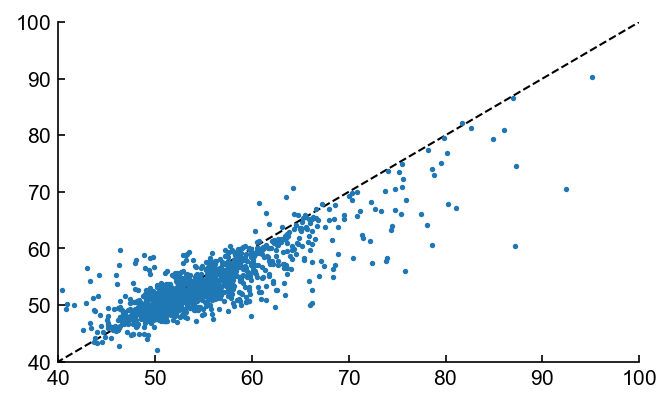

In [21]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(100*dec_1,100*dec_2,s=2.5)
ax.plot([0,100],[0,100],c='k',linestyle='--',lw=1,zorder=-1)
ax.set_xlim([40,100])
ax.set_ylim([40,100])
#ax.set_xlabel('New decoding accuracy (%)')
#ax.set_ylabel('Old decoding accuracy (%)')
#plt.savefig(os.path.join('D:\\\\TempFigures','Trimmed whole-trial decoding vs old decoding.pdf'),transparent=False,facecolor="white")

1440it [00:00, 6152.44it/s]
229it [00:00, 2289.36it/s]

pre early mean goes from 0.5295752326255323 to 0.5384233671964006
pre early median goes from 0.5176128378378378 to 0.5225258457471511


1440it [00:00, 4832.68it/s]
1440it [00:00, 7824.30it/s] 

pre late mean goes from 0.5291539129156063 to 0.5428483902518084
pre late median goes from 0.5273678113553113 to 0.5360333333333333



367it [00:00, 3632.83it/s]

pre expert mean goes from 0.55115621623586 to 0.5802898714794246
pre expert median goes from 0.5345843663274746 to 0.5683333333333332


1440it [00:00, 2558.45it/s]
601it [00:00, 6008.63it/s]

post early mean goes from 0.5381358611952262 to 0.5534325281726087
post early median goes from 0.5278845065312047 to 0.5408398268398268


1440it [00:00, 3082.81it/s]
1440it [00:00, 8725.08it/s]


post late mean goes from 0.541056249927493 to 0.5559043371362403
post late median goes from 0.5299360000000001 to 0.5470307692307692
post expert mean goes from 0.5437841973262993 to 0.5525509017490056
post expert median goes from 0.5343073529411764 to 0.541197463768116


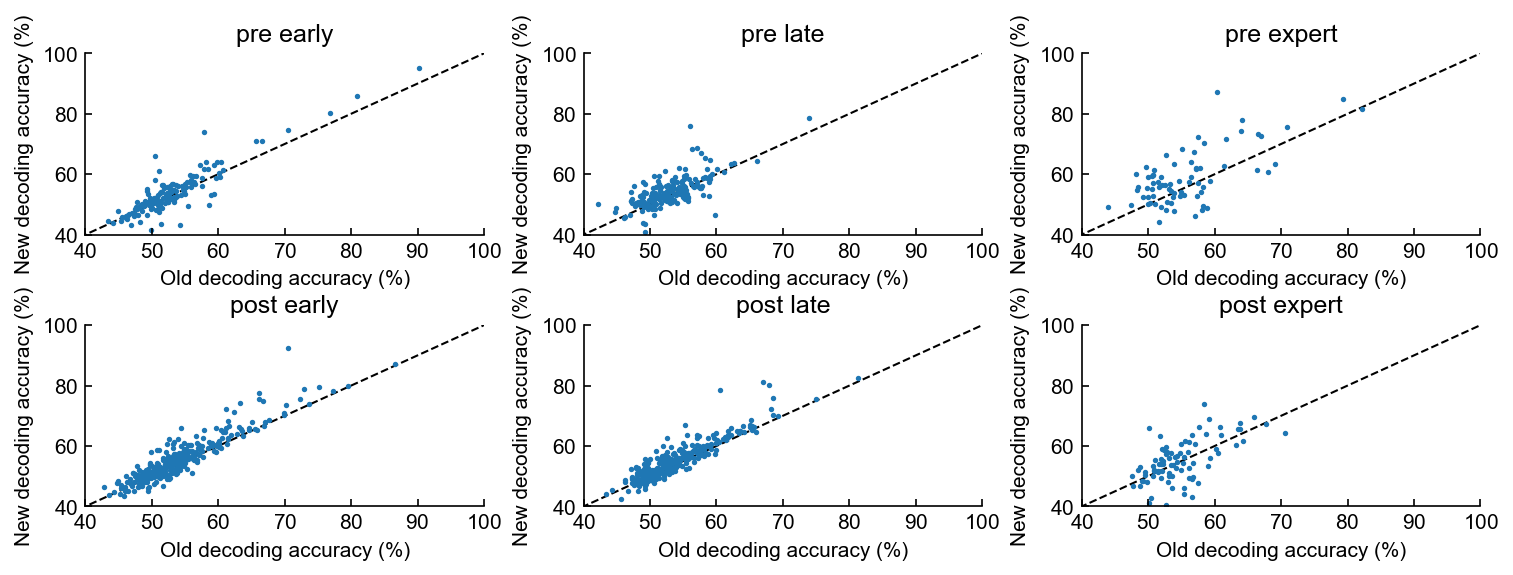

In [38]:
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(2,3,wspace=0.25,hspace=0.5)
axs = [plt.subplot(gs[i,j]) for i,j in product(range(2),range(3))]
    
for phase_idx,phase in enumerate(['pre early','pre late','pre expert','post early','post late','post expert']):

    dec = []
    old_dec = []
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        if EILphases[idx] == phase:
            dec.append(getDataPoint(stim_25s_df,session,clust,'stimulus','accuracy'))
            #old_dec.append(getDataPoint(old_dec_df,session,clust,'stimulus','accuracy'))
            old_dec.append(getOldDataPoint(old_dec_df,session,clust,'accuracies'))
    dec = np.array(dec)
    old_dec = np.array(old_dec)
    
    print(f"{phase} mean goes from {np.nanmean(old_dec)} to {np.nanmean(dec)}")
    print(f"{phase} median goes from {np.nanmedian(old_dec)} to {np.nanmedian(dec)}")
    
    ax = axs[phase_idx]
    ax.set_title(phase)
    
    ax.scatter(100*old_dec,100*dec,s=2.5)
    ax.plot([0,100],[0,100],c='k',linestyle='--',lw=1,zorder=-1)
    ax.set_xlim([40,100])
    ax.set_ylim([40,100])
    ax.set_xlabel('Old decoding accuracy (%)')
    ax.set_ylabel('New decoding accuracy (%)')
    
plt.savefig(os.path.join('D:\\\\TempFigures','Old vs New decoding by phase.pdf'),transparent=False,facecolor="white")

1440it [00:09, 153.91it/s]
1440it [00:09, 153.99it/s]
1440it [00:09, 151.09it/s]
1440it [00:09, 152.28it/s]
1440it [00:09, 156.10it/s]
1440it [00:09, 154.26it/s]
1440it [00:10, 142.84it/s]
1440it [00:09, 155.41it/s]
1440it [00:09, 154.84it/s]
1440it [00:09, 154.27it/s]
1440it [00:09, 152.10it/s]
1440it [00:09, 153.08it/s]
1440it [00:09, 155.11it/s]


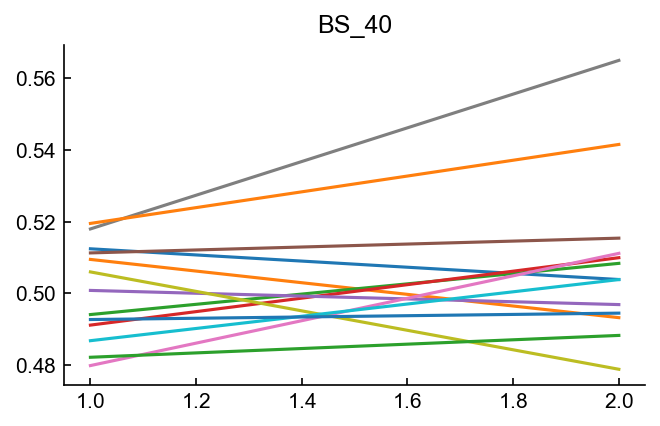

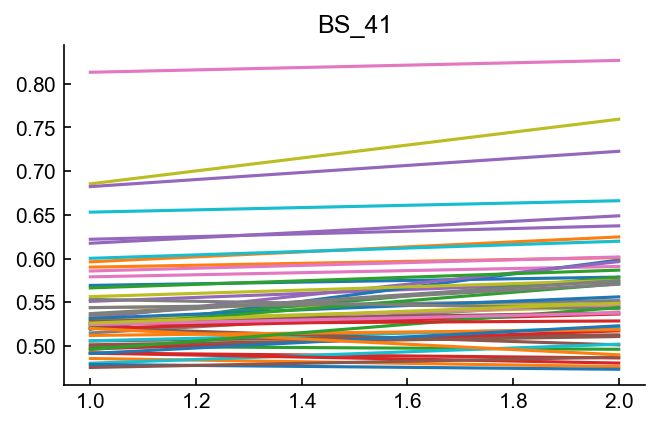

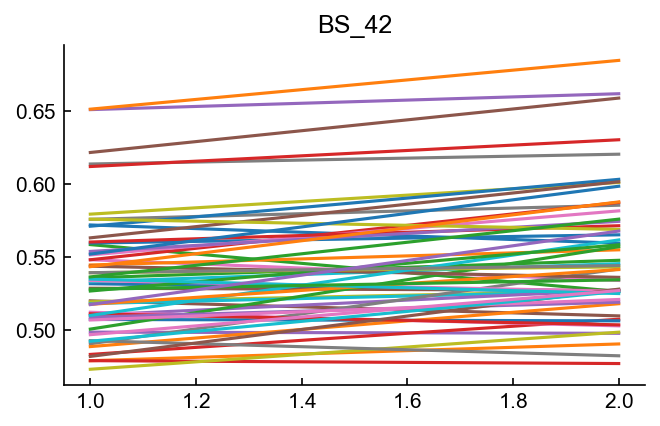

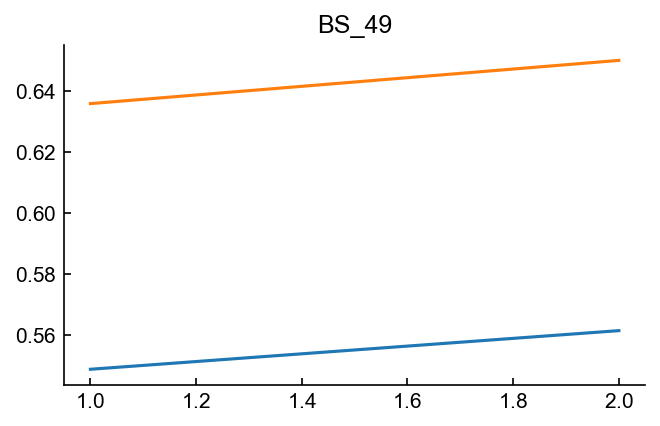

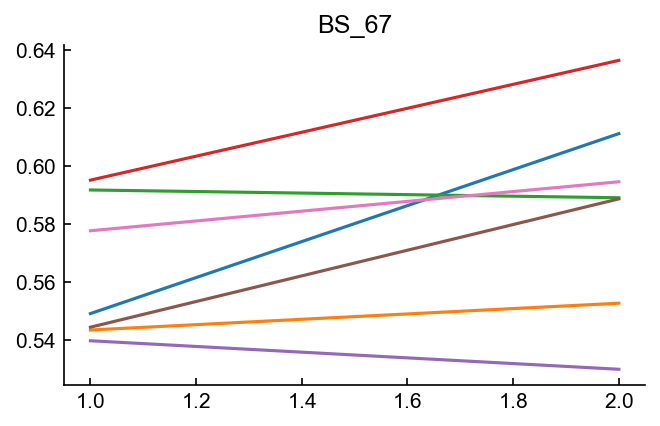

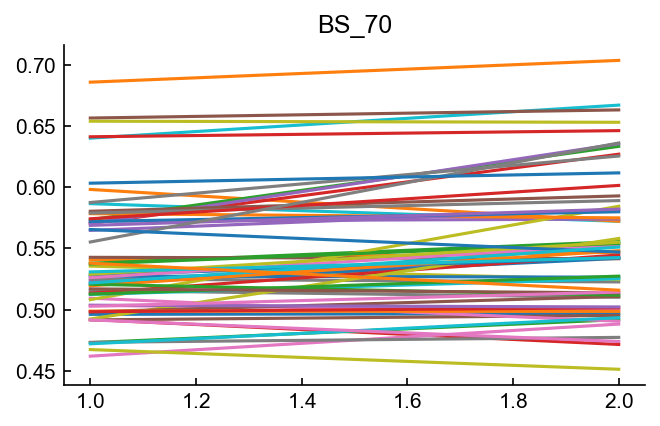

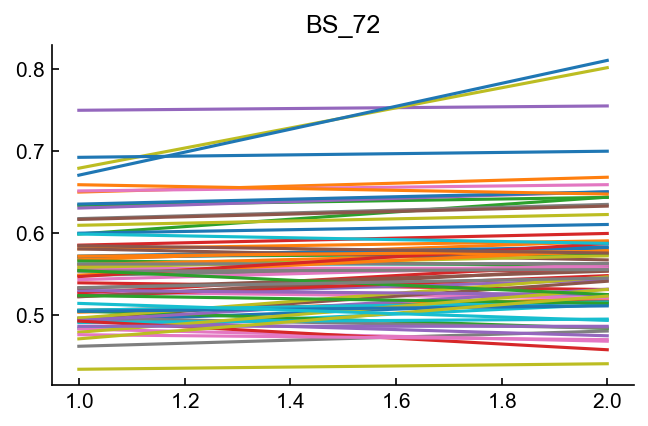

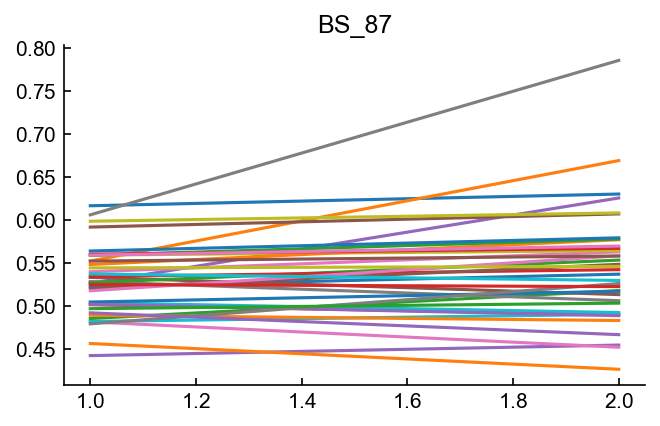

In [33]:
for animal in animals:
    new = []
    old = []
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)
        if EILphases[idx] == 'post late' and sessionfile.meta.animal == animal:
            new.append(getDataPoint(stim_25s_df,session,clust,'stimulus','accuracy'))
            old.append(getOldDataPoint(old_dec_df,session,clust,'accuracies'))
    
    new = np.array(new)
    old = np.array(old)
    
    #Skip all with no data
    if len(new) == 0 and len(old) == 0:
        continue
    
    fig, ax = plt.subplots(figsize=(5,3))
    ax.set_title(animal)
    
    ax.plot([np.ones_like(old),np.ones_like(new)*2],[old,new])

In [ ]:
def plotActiveTrials(outcomes,max_trim=1000,window_length=50,active_threshold=0.8,sated_threshold=0.1):
    hits = np.equal(outcomes,1)
    misses = np.equal(outcomes,2)
    falarms = np.equal(outcomes,3)
    crejects = np.equal(outcomes,4)
    gos = np.logical_or(hits,falarms)
    nogos = np.logical_or(misses,crejects)

    #Disable max trim
    #max_trim = len(outcomes)
    max_trim = min(len(outcomes),max_trim)
    
    #Determine lick rate over time
    number_windows = len(outcomes) - window_length + 1
    lick_rates = np.full(number_windows,np.nan)
    for window_idx in range(number_windows):
        
        window_trials = list(range(window_idx,window_idx+window_length))
        window_gos = gos[window_trials]
        
        window_lick_rate = np.mean(window_gos)
        lick_rates[window_idx] = window_lick_rate
        
    #Find where lick rate is acceptable -- overlicking
    lick_rates_below_threshold = np.less_equal(lick_rates,active_threshold)
    first_valid_window = number_windows
    if np.sum(lick_rates_below_threshold) > 0:
        first_valid_window = np.min(np.where(lick_rates_below_threshold)[0])
    first_valid_window = int(  min(max_trim,first_valid_window) + 0.5*window_length  )
    if lick_rates[0] < active_threshold:
        first_valid_window = 0
    
    #Final result from first trim -- trials that are not overlicking
    valid_trials_overlicking = list(range(first_valid_window,len(outcomes)))
    valid_trials_overlicking = np.array(valid_trials_overlicking)
    
    #############################################################################
    
    #Find where lick rate is acceptable -- overlicking
    lick_rates_above_threshold = np.greater_equal(lick_rates,sated_threshold)
    last_valid_window = 0
    if np.sum(lick_rates_above_threshold) > 0:
        last_valid_window = np.max(np.where(lick_rates_above_threshold)[0])
    last_valid_window = int(  max(len(outcomes)-max_trim,last_valid_window) + 0.5*window_length  )
    #if lick_rates[len(lick_rates)-1] > sated_threshold:
    #    last_valid_window = len(lick_rates)-1 + window_length
    
    valid_trials_sated = list(range(0,last_valid_window))
    valid_trials_sated = np.array(valid_trials_sated)
    
    #############################################################################
    
    valid_trials = valid_trials_overlicking[np.isin(valid_trials_overlicking,valid_trials_sated)]
    
    #trimmed_outcomes = outcomes[valid_trials]    
    #return lick_rates,hits,falarms,valid_trials,trimmed_outcomes
    
    
    

In [27]:
sessionfile = ilep.getRandomSession(act_directory)
sessionfile.meta

namespace(directory='D:\\BS_70\\BS_70 8\\AC\\',
          region='AC',
          animal='BS_70',
          probe=7372,
          date='12/1/2021',
          depth=995,
          task='reversal',
          day_of_training=12,
          day_of_recording=8,
          day_of_reversal=4,
          length_in_samples=74278343.0,
          files=['December 1 2021 Dual BS_70_8001',
                 'December 1 2021 Dual BS_70_8002',
                 'December 1 2021 Dual BS_70_8003',
                 'December 1 2021 Dual BS_70_8004'],
          behavior='naive',
          condition='postreversal naive',
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=2475.9447666666665,
          length_in_minutes=41.265746111111106,
          length_in_trials=490)

In [31]:
conditions = ilep.getAllConditions(sessionfile,sessionfile.clusters.good[0],trialsPerDayLoaded='NO_TRIM')
conditions['all_trials'].trials

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [33]:
def getOutcomesFromSession(sessionfile):
    outcomes = np.full_like(sessionfile.trials.starts,np.nan)
    hits = np.logical_and(sessionfile.trials.go,sessionfile.trials.target)
    misses = np.logical_and(np.logical_not(sessionfile.trials.go),sessionfile.trials.target)
    falarms = np.logical_and(sessionfile.trials.go,np.logical_not(sessionfile.trials.target))
    crejects = np.logical_and(np.logical_not(sessionfile.trials.go),np.logical_not(sessionfile.trials.target))
    outcomes[hits] = 1*np.ones(np.sum(hits))
    outcomes[misses] = 2*np.ones(np.sum(misses))
    outcomes[falarms] = 3*np.ones(np.sum(falarms))
    outcomes[crejects] = 4*np.ones(np.sum(crejects))
    return outcomes

In [34]:
def pcdpfromoutcomes(outcomes):
    hit = np.sum(np.equal(outcomes,1))
    miss = np.sum(np.equal(outcomes,2))
    falarm = np.sum(np.equal(outcomes,3))
    creject = np.sum(np.equal(outcomes,4))

    pc = (hit+creject)/(hit+miss+falarm+creject)
    dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
    
    return pc,dp

In [35]:
def trimActiveTrialExpertRestricted(outcomes,max_trim=150,window_length=50,active_threshold=0.8,sated_threshold=0.1):
    hits = np.equal(outcomes,1)
    misses = np.equal(outcomes,2)
    falarms = np.equal(outcomes,3)
    crejects = np.equal(outcomes,4)
    gos = np.logical_or(hits,falarms)
    nogos = np.logical_or(misses,crejects)
    
    #Disable max trim
    #max_trim = len(outcomes)
    max_trim = min(len(outcomes),max_trim)
    
    #Determine lick rate over time
    number_windows = len(outcomes) - window_length + 1
    lick_rates = np.full(number_windows,np.nan)
    for window_idx in range(number_windows):
        
        window_trials = list(range(window_idx,window_idx+window_length))
        window_gos = gos[window_trials]
        
        window_lick_rate = np.mean(window_gos)
        lick_rates[window_idx] = window_lick_rate
        
    #Find where lick rate is acceptable -- overlicking
    lick_rates_below_threshold = np.less_equal(lick_rates,active_threshold)
    first_valid_window = number_windows
    if np.sum(lick_rates_below_threshold) > 0:
        first_valid_window = np.min(np.where(lick_rates_below_threshold)[0])
    first_valid_window = int(  min(max_trim,first_valid_window) + 0.5*window_length  )
    if lick_rates[0] < active_threshold:
        first_valid_window = 0
    
    #Final result from first trim -- trials that are not overlicking
    valid_trials_overlicking = list(range(first_valid_window,len(outcomes)))
    valid_trials_overlicking = np.array(valid_trials_overlicking)
    
    #############################################################################
    
    #Find where lick rate is acceptable -- overlicking
    lick_rates_above_threshold = np.greater_equal(lick_rates,sated_threshold)
    last_valid_window = 0
    if np.sum(lick_rates_above_threshold) > 0:
        last_valid_window = np.max(np.where(lick_rates_above_threshold)[0])
    last_valid_window = int(  max(len(outcomes)-max_trim,last_valid_window) + 0.5*window_length  )
    #if lick_rates[len(lick_rates)-1] > sated_threshold:
    #    last_valid_window = len(lick_rates)-1 + window_length
    
    valid_trials_sated = list(range(0,last_valid_window))
    valid_trials_sated = np.array(valid_trials_sated)
    
    #############################################################################
    
    valid_trials = valid_trials_overlicking[np.isin(valid_trials_overlicking,valid_trials_sated)]
    trimmed_outcomes = outcomes[valid_trials]
        
    return lick_rates,hits,falarms,valid_trials,trimmed_outcomes

1440it [00:08, 171.39it/s]


0.7732817780180004
1.740185490278364
mean active 221.8 median active 240.0
mean active 127.19417475728156 median active 131.0


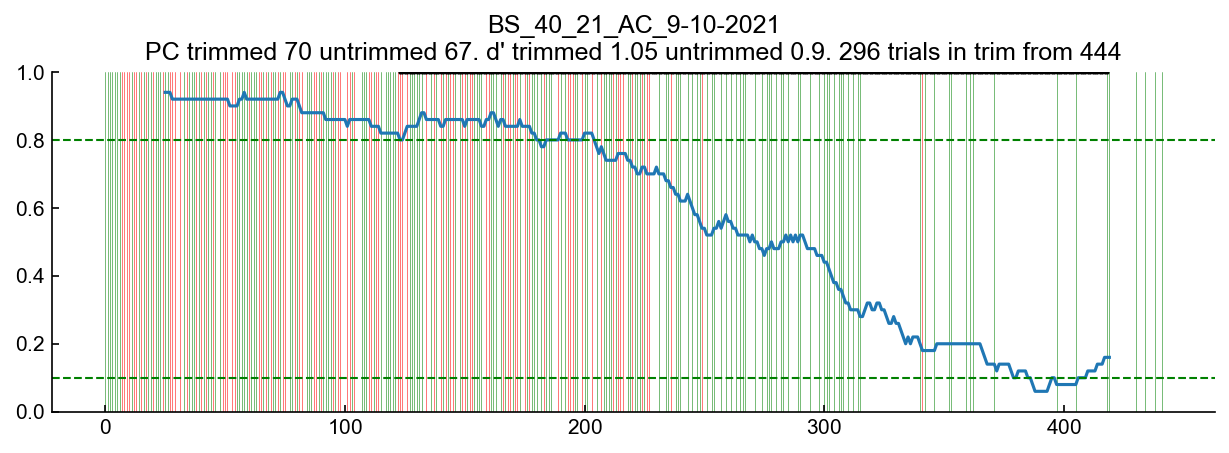

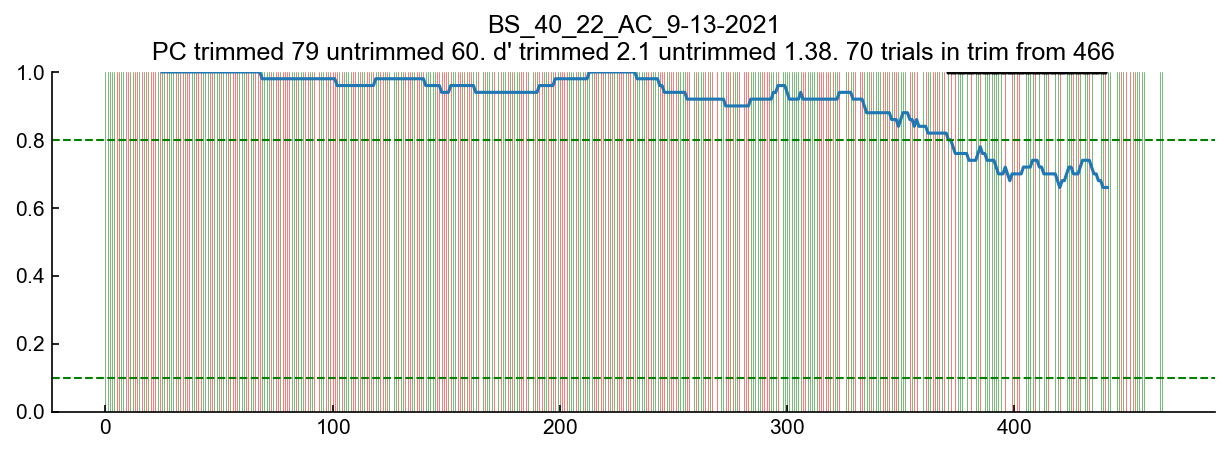

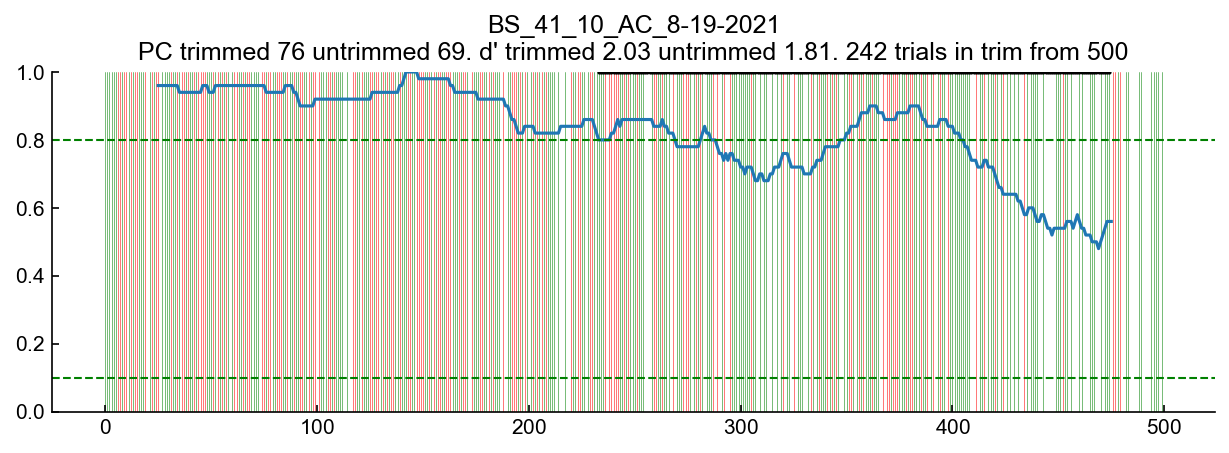

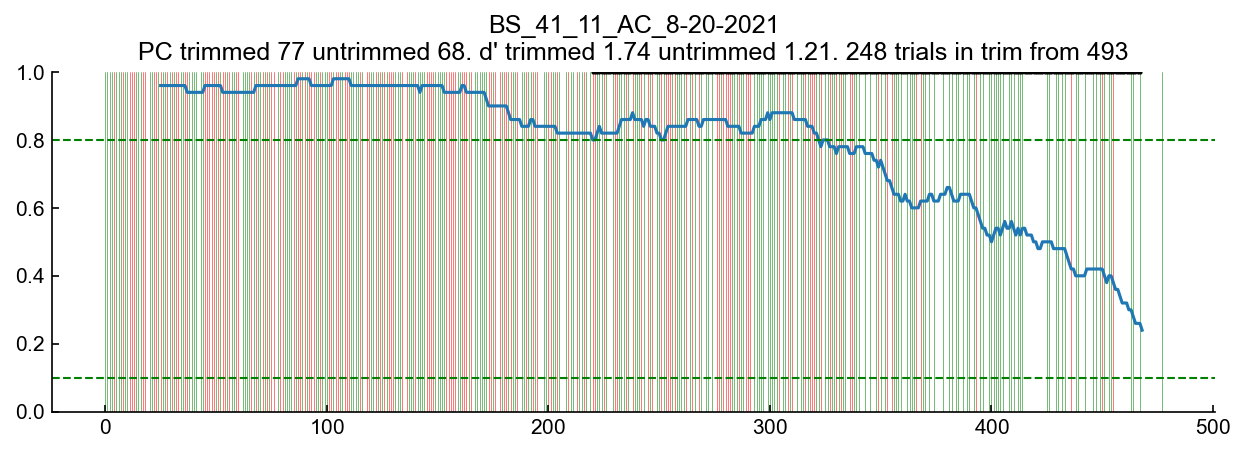

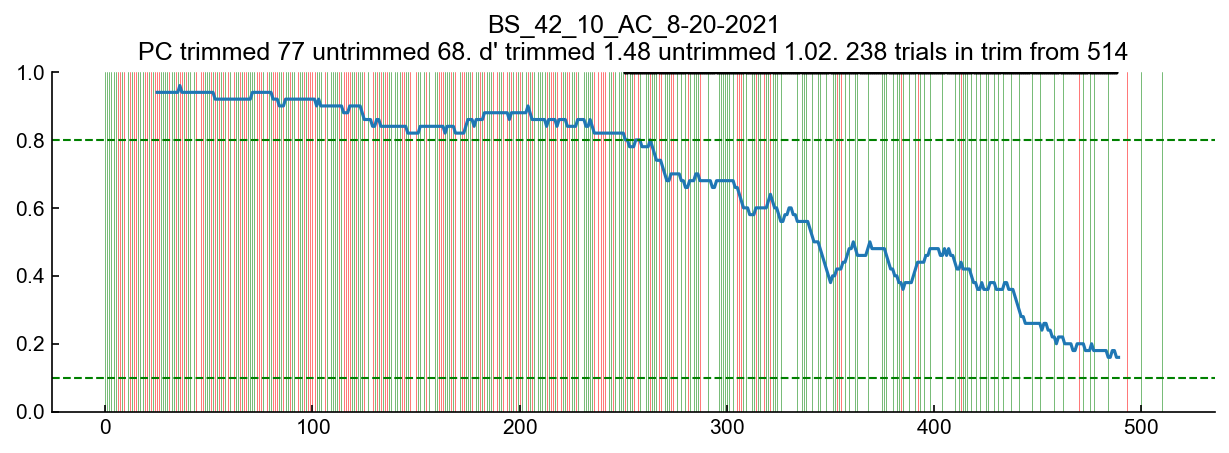

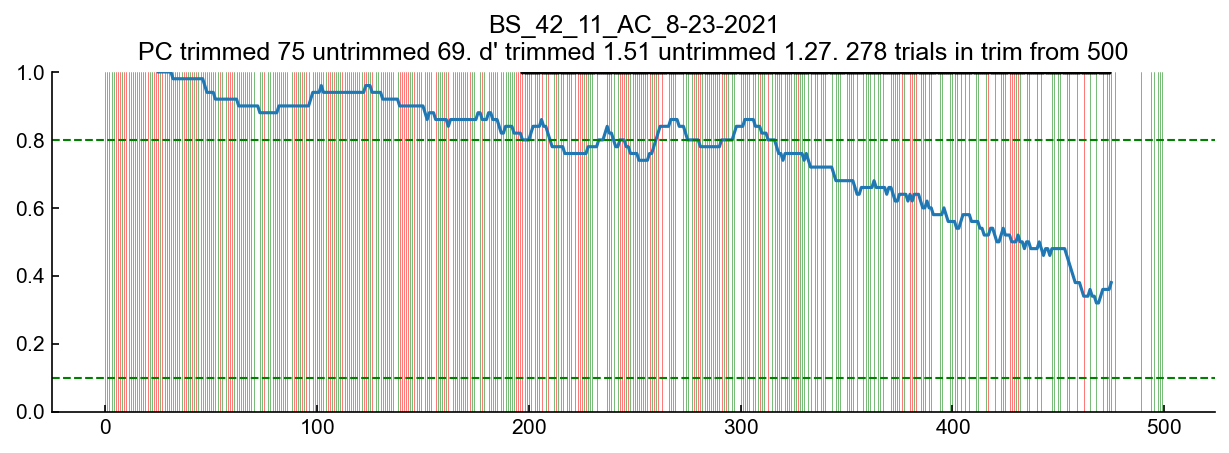

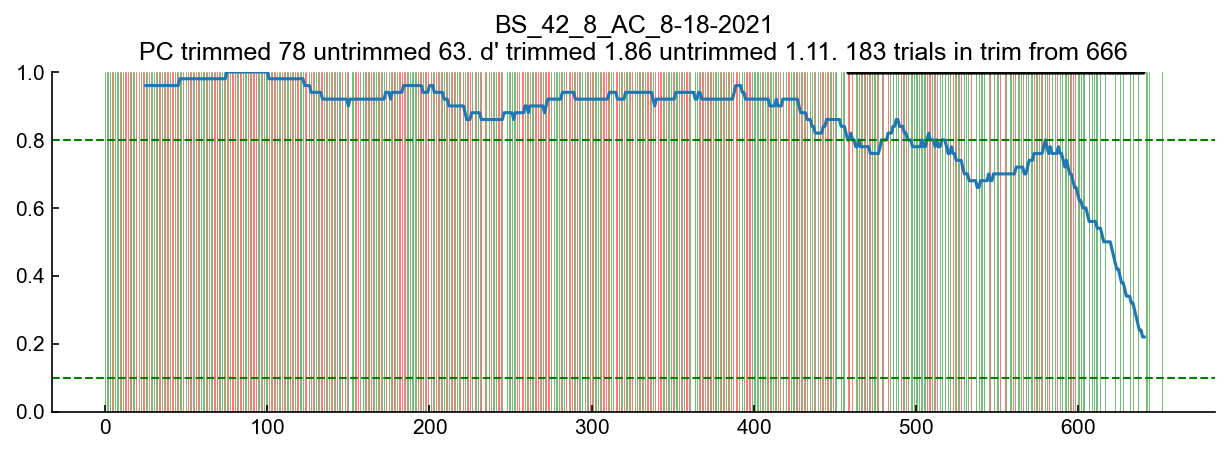

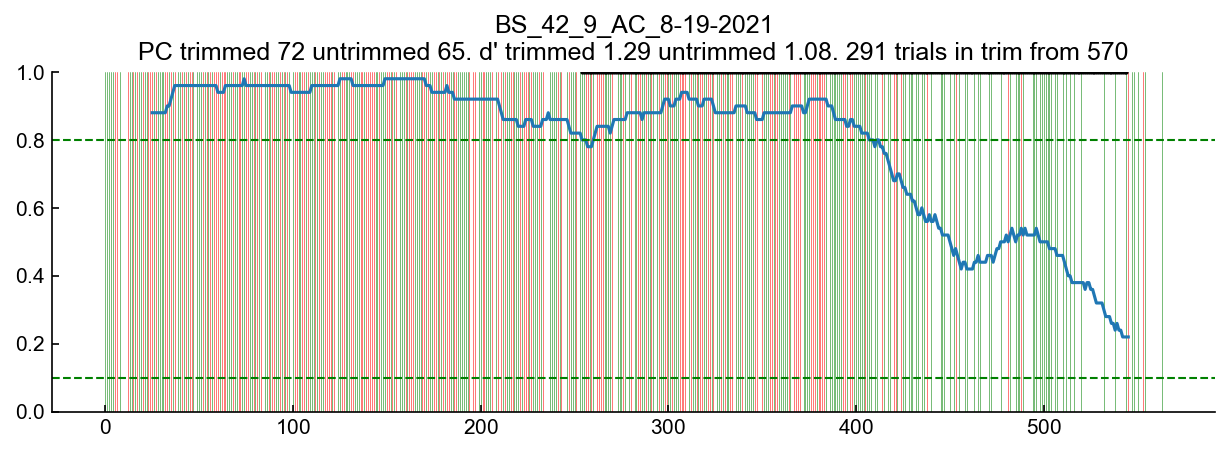

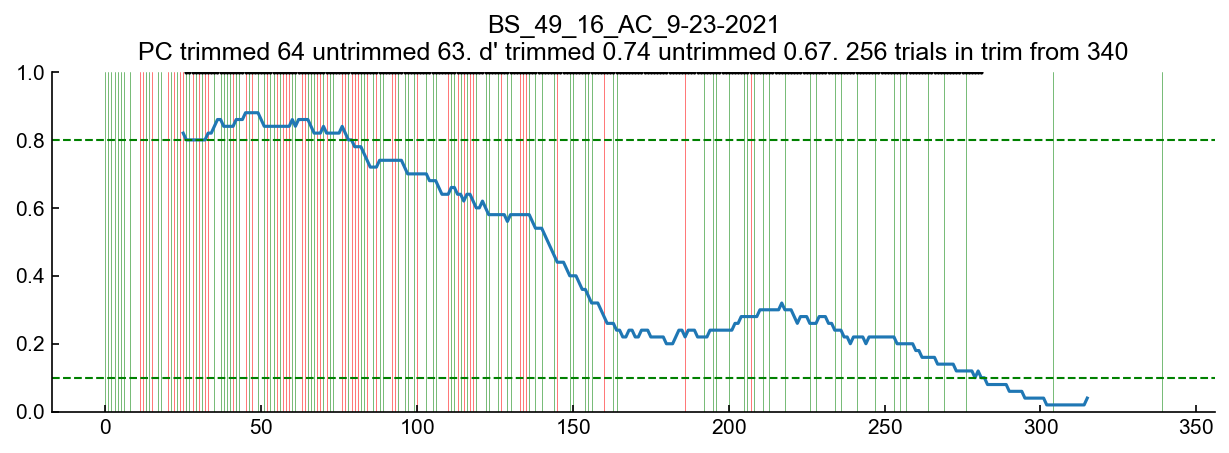

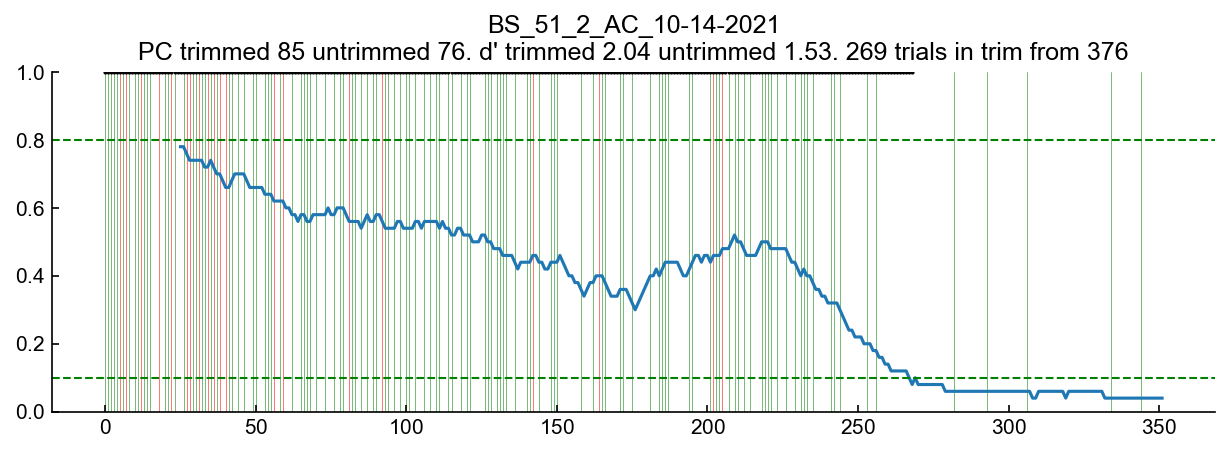

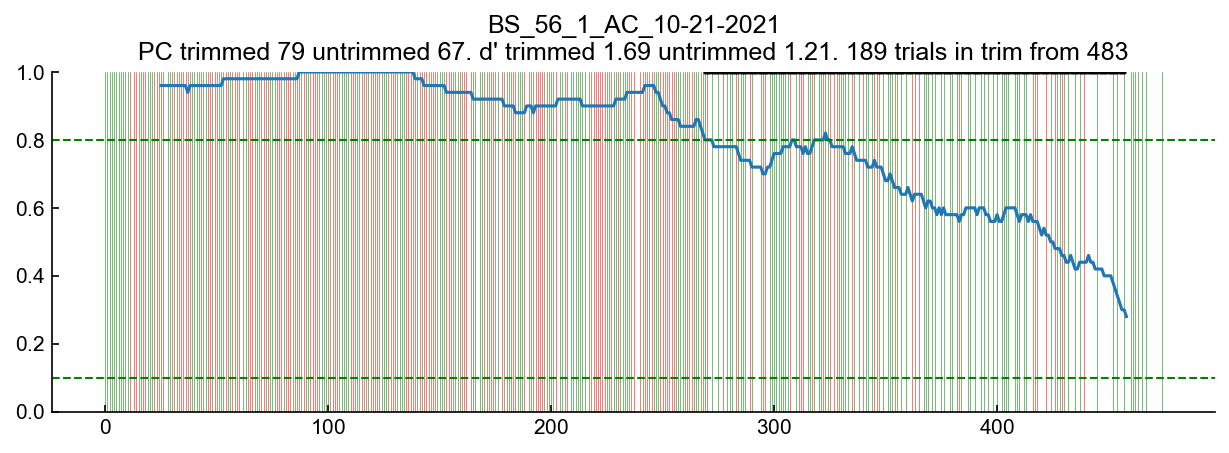

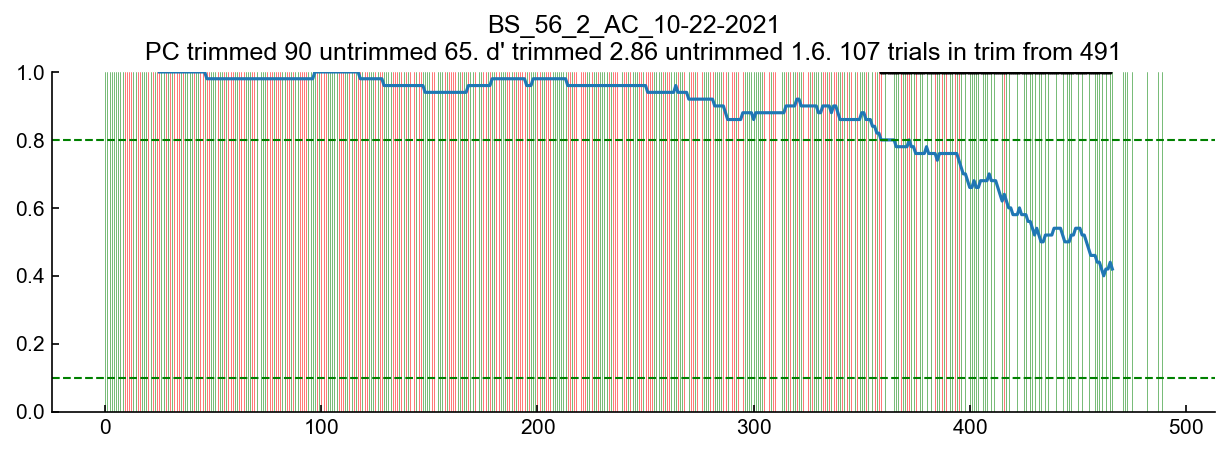

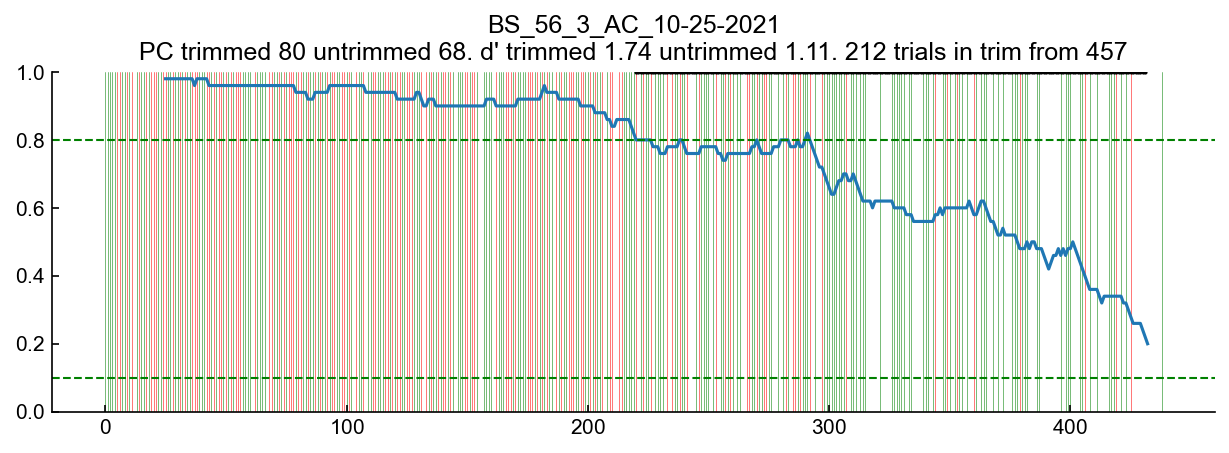

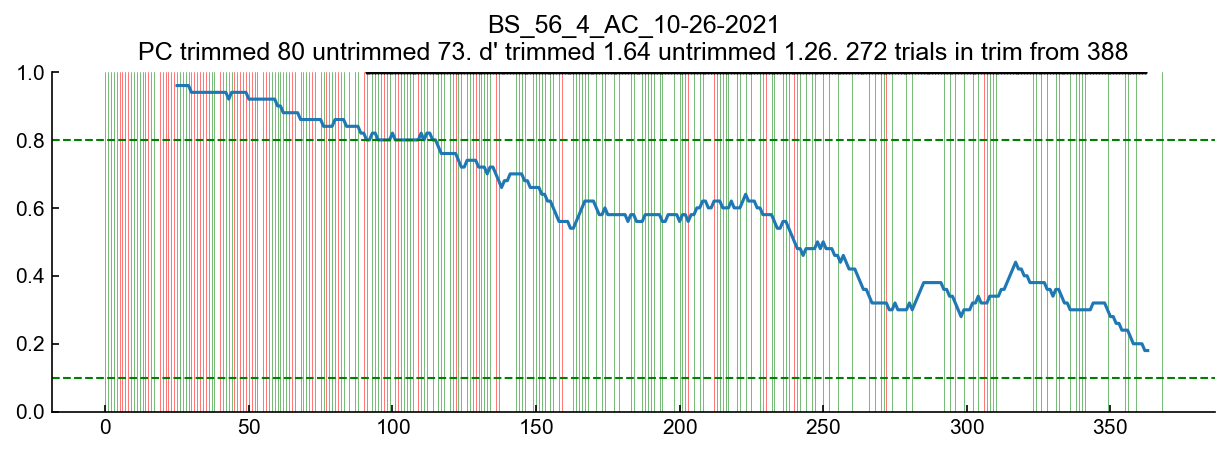

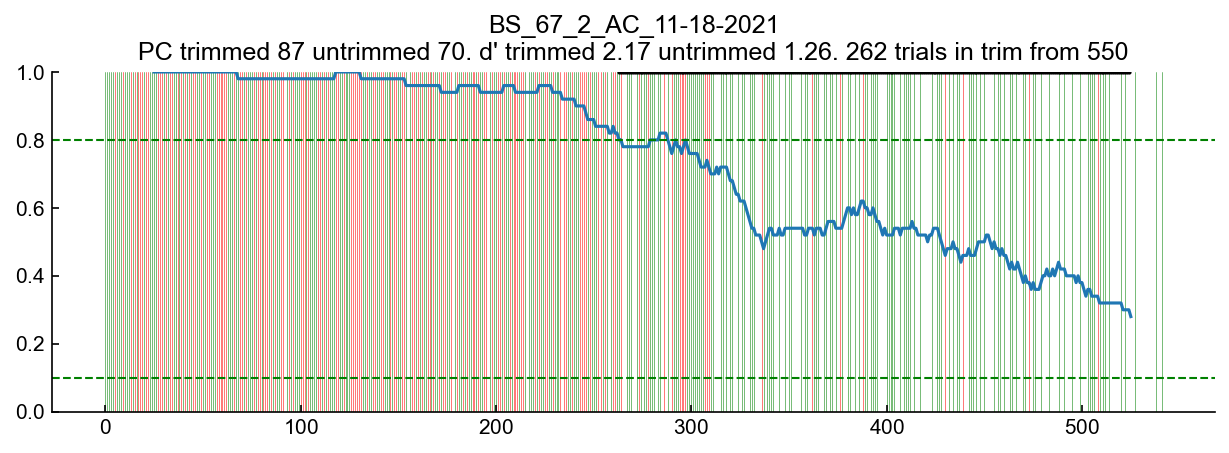

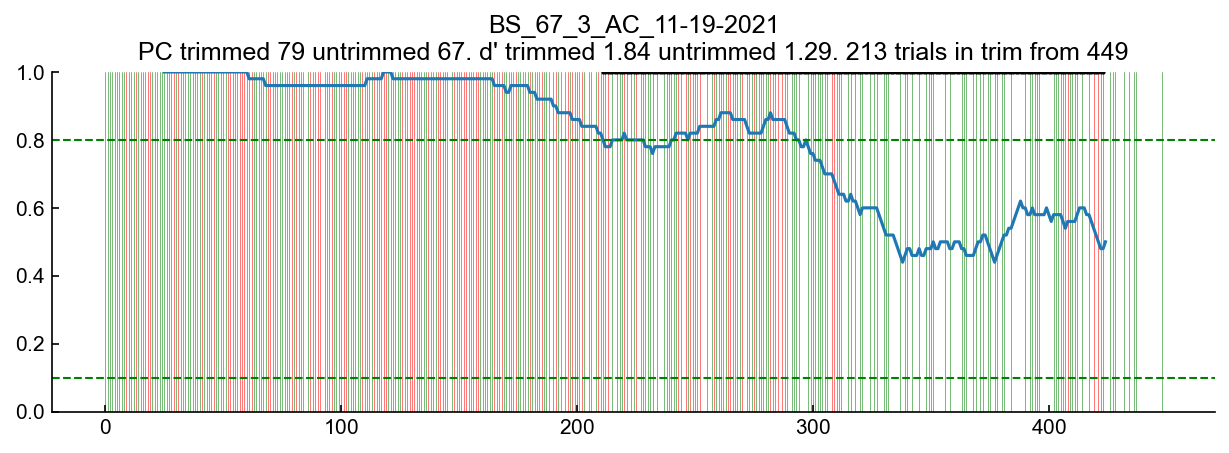

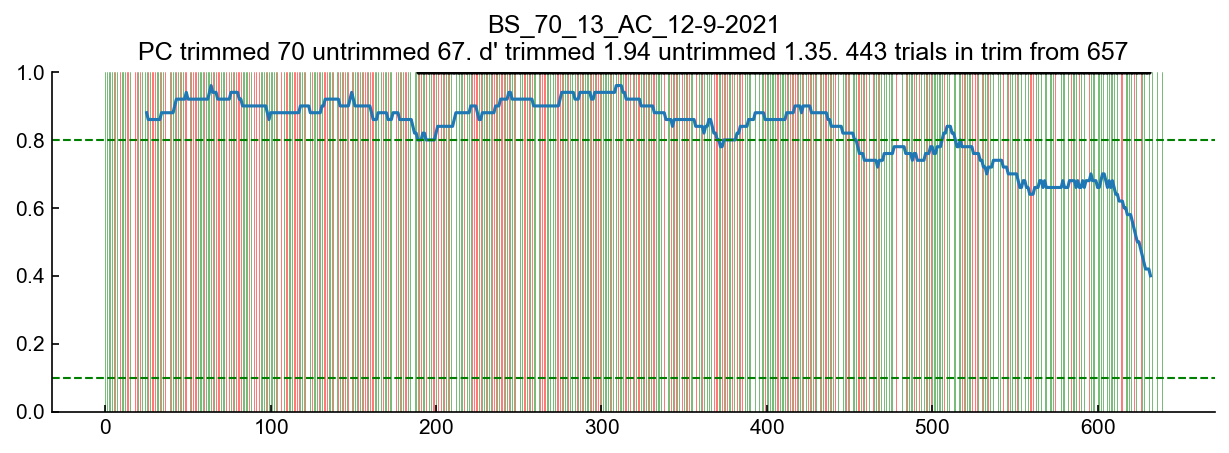

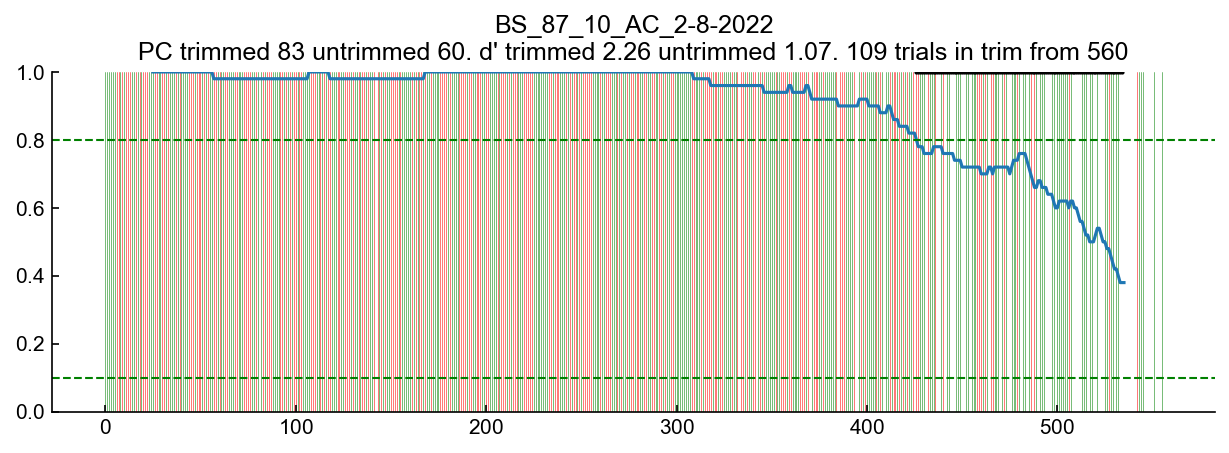

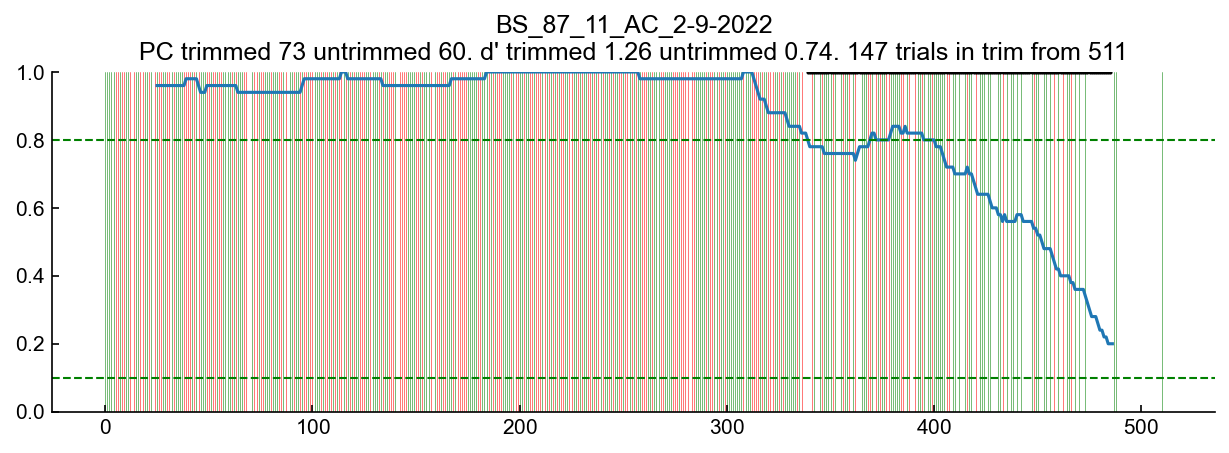

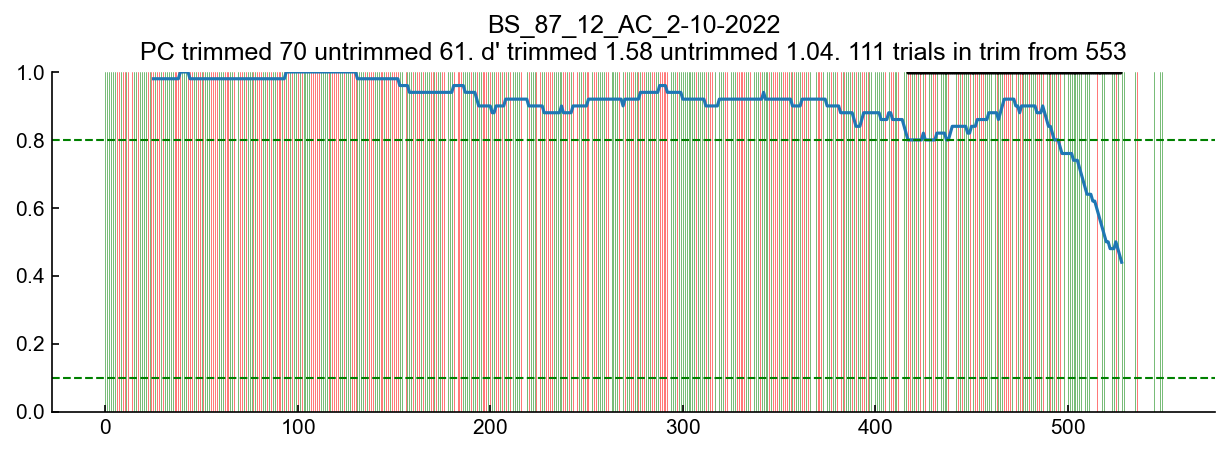

In [57]:
PCts = []
dpts = []

num_trials_active = []
num_trials_neuron = []

num_sessions = 0
old_session = None
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    if session == old_session:
        continue
    old_session = session
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not EILphases[idx] in ['post expert']:
        continue

    outcomes = getOutcomesFromSession(sessionfile)
    lick_rates,hits,falarms,valid_trials,trimmed_outcomes = trimActiveTrialExpertRestricted(outcomes,max_trim = 1000)
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(np.array(range(len(lick_rates)))+50/2,lick_rates)
    [ax.axvline(hit,zorder=-10,lw=0.25,c='green') for hit in np.where(hits)[0]]
    [ax.axvline(falarm,zorder=-10,lw=0.25,c='red') for falarm in np.where(falarms)[0]]
    ax.scatter(valid_trials,np.ones_like(valid_trials),s=1,c='k')
    ax.axhline(0.8,c='g',linestyle='--',lw=1)
    ax.axhline(0.1,c='g',linestyle='--',lw=1)
    ax.set_ylim([0,1])
    
    PCt,dpt = pcdpfromoutcomes(trimmed_outcomes)
    PCu,dpu = pcdpfromoutcomes(outcomes)
    PCts.append(PCt)
    dpts.append(dpt)
    
    #print(session)
    #print(f"PC trimmed {round(100*PCt)} untrimmed {round(100*PCu)}. d' trimmed {round(100*dpt)/100} untrimmed {round(100*dpu)/100}. {len(trimmed_outcomes)} trials in trim from {len(outcomes)}")
    ax.set_title(f"{ilep.generateDateString(sessionfile)}\nPC trimmed {round(100*PCt)} untrimmed {round(100*PCu)}. d' trimmed {round(100*dpt)/100} untrimmed {round(100*dpu)/100}. {len(trimmed_outcomes)} trials in trim from {len(outcomes)}")
    
    if num_sessions >= 10:
        pass
    
    num_trials_active.append(len(trimmed_outcomes))
    for clust in sessionfile.clusters.good:
        conditions = ilep.getAllConditions(sessionfile,clust)
        num_trials_neuron.append(len(conditions['all_trials'].trials))
        
    #fig.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Session trimming',ilep.generateDateString(sessionfile)+' active trimming.pdf'),transparent=False,facecolor="white")
    fig.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Session trimming',ilep.generateDateString(sessionfile)+' active trimming.png'),transparent=False,facecolor="white")
    
print(np.mean(PCts))
print(np.mean(dpts))

print(f"mean active {np.mean(num_trials_active)} median active {np.median(num_trials_active)}")
print(f"mean active {np.mean(num_trials_neuron)} median active {np.median(num_trials_neuron)}")

In [38]:
num_trials_active

[296,
 70,
 242,
 248,
 238,
 278,
 183,
 291,
 256,
 269,
 189,
 107,
 212,
 272,
 262,
 213,
 443,
 109,
 147,
 111]

In [60]:
num_trials_neuron

[142,
 11,
 0,
 0,
 142,
 62,
 66,
 142,
 142,
 63,
 60,
 142,
 0,
 67,
 67,
 67,
 67,
 95,
 131,
 131,
 131,
 131,
 131,
 131,
 131,
 131,
 131,
 131,
 131,
 131,
 0,
 131,
 131,
 131,
 221,
 221,
 221,
 221,
 221,
 167,
 181,
 221,
 0,
 137,
 137,
 137,
 116,
 177,
 137,
 137,
 61,
 61,
 61,
 139,
 273,
 273,
 273,
 211,
 211,
 211,
 66,
 211,
 211,
 211,
 211,
 0,
 211,
 80,
 211,
 211,
 211,
 211,
 211,
 211,
 211,
 211,
 245,
 245,
 234,
 10,
 20,
 133,
 10,
 0,
 0,
 0,
 234,
 46,
 41,
 36,
 259,
 259,
 259,
 88,
 77,
 77,
 0,
 77,
 0,
 34,
 34,
 34,
 34]

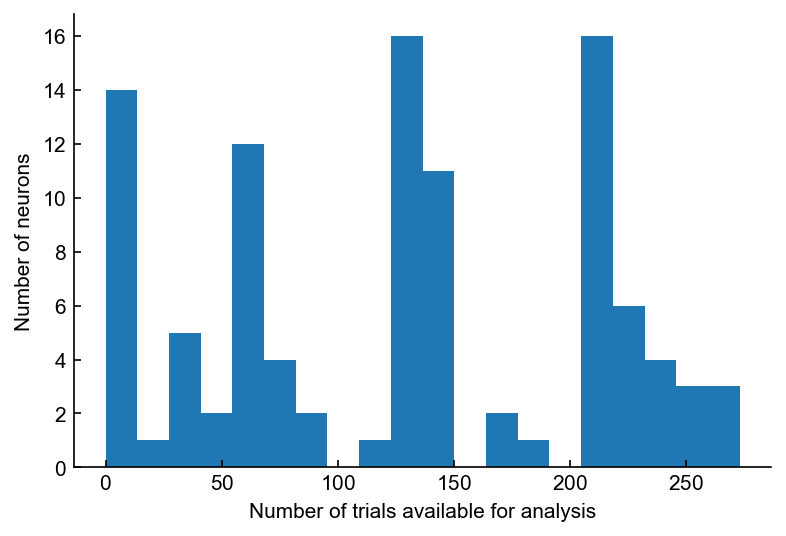

In [59]:
plt.hist(num_trials_neuron,bins=20)
plt.ylabel('Number of neurons')
plt.xlabel('Number of trials available for analysis')
plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Session trimming','available trials histogram.png'),transparent=False,facecolor="white")

In [89]:
is_TE_old = is_TE_s

In [86]:
is_TE_new = is_TE_s

In [97]:
np.mean(is_TE_old)

0.30694444444444446

In [98]:
np.mean(is_TE_new)

0.2604166666666667

In [99]:
np.mean(is_TE_old != is_TE_new)

0.17430555555555555

In [100]:
np.mean(np.logical_and(is_TE_new,np.logical_not(is_TE_old)))

0.06388888888888888

In [101]:
np.mean(np.logical_and(is_TE_old,np.logical_not(is_TE_new)))

0.11041666666666666

In [108]:
idxs2 = np.where(np.logical_and(is_TE_new,np.logical_not(is_TE_old)))[0]

idxs = np.where(np.logical_and(is_TE_old,np.logical_not(is_TE_new)))[0]
idxs

array([   2,    3,   16,   35,   39,   44,   75,   91,   92,   94,   95,
         98,  124,  140,  145,  167,  170,  173,  176,  187,  188,  192,
        200,  206,  224,  225,  238,  251,  255,  260,  273,  279,  289,
        303,  306,  330,  378,  394,  446,  463,  525,  534,  551,  580,
        602,  610,  630,  708,  765,  771,  773,  776,  778,  783,  793,
        804,  811,  847,  850,  860,  863,  881,  883,  885,  887,  889,
        890,  929,  939,  943,  992, 1013, 1016, 1019, 1025, 1034, 1051,
       1055, 1080, 1105, 1108, 1119, 1129, 1134, 1147, 1156, 1160, 1200,
       1217, 1220, 1223, 1259, 1264, 1286, 1292, 1293, 1294, 1295, 1296,
       1297, 1300, 1303, 1313, 1315, 1316, 1317, 1318, 1319, 1320, 1321,
       1322, 1323, 1326, 1327, 1332, 1334, 1337, 1338, 1340, 1341, 1343,
       1349, 1350, 1351, 1352, 1353, 1354, 1356, 1358, 1361, 1363, 1364,
       1365, 1367, 1372, 1376, 1380, 1392, 1394, 1395, 1397, 1398, 1402,
       1405, 1406, 1409, 1410, 1411, 1413, 1414, 14

In [112]:
EILphases[idxs]

array(['pre expert', 'pre expert', 'switch', 'switch', 'switch',
       'post early', 'pre late', 'pre expert', 'pre expert', 'pre expert',
       'pre expert', 'pre expert', 'post early', 'post early',
       'post early', 'post expert', 'post expert', 'post expert',
       'post expert', 'pre late', 'pre late', 'pre late', 'pre late',
       'pre late', 'pre late', 'pre late', 'pre late', 'pre late',
       'pre late', 'pre late', 'pre late', 'pre late', 'pre late',
       'post expert', 'post expert', 'switch', 'post early', 'post early',
       'post late', 'post expert', 'post early', 'post early',
       'post early', 'post early', 'post late', 'post late', 'post late',
       'pre early', 'pre early', 'pre early', 'pre early', 'pre early',
       'pre early', 'pre early', 'pre late', 'pre late', 'pre early',
       'post expert', 'post expert', 'post expert', 'post expert',
       'post expert', 'post expert', 'post expert', 'post expert',
       'post expert', 'post expert', 'p

In [109]:
EILphases[idxs2]

array(['switch', 'pre expert', 'pre expert', 'pre expert', 'post expert',
       'post expert', 'post expert', 'pre late', 'pre late', 'pre late',
       'pre late', 'pre late', 'pre late', 'pre late', 'pre late',
       'post expert', 'switch', 'switch', 'switch', 'switch',
       'post early', 'post early', 'post early', 'post early',
       'post early', 'post early', 'post early', 'post early',
       'post early', 'post late', 'post late', 'post late', 'post late',
       'post late', 'post late', 'post early', 'post early', 'post early',
       'post early', 'post early', 'post early', 'post early',
       'post late', 'post late', 'post late', 'post late', 'pre expert',
       'pre expert', 'pre expert', 'post expert', 'pre early',
       'pre early', 'pre early', 'pre early', 'pre early', 'pre late',
       'post expert', 'post expert', 'post late', 'post late',
       'post late', 'pre late', 'pre late', 'pre late', 'pre late',
       'pre late', 'pre late', 'pre late', 'switc

In [110]:
len(idxs)

159

In [111]:
len(idxs2)

92

In [113]:
np.sum(np.char.equal(EILphases[idxs],'post expert'))

18

In [114]:
np.sum(np.char.equal(EILphases[idxs2],'post expert'))

10

In [117]:
TE_to_nonTE_mask = np.logical_and(is_TE_old,np.logical_not(is_TE_new))
TE_to_nonTE_PE_mask = np.logical_and(TE_to_nonTE_mask,np.char.equal(EILphases,'post expert'))
TE_to_nonTE_PE_idx_list = np.where(TE_to_nonTE_PE_mask)[0]
for idx in TE_to_nonTE_PE_idx_list:
    print(f"session {EnumSession[idx]} cluster {EnumClust[idx]} went from TE to non-TE")

session BS_40_21_AC.pickle cluster 8 went from TE to non-TE
session BS_40_21_AC.pickle cluster 32 went from TE to non-TE
session BS_40_21_AC.pickle cluster 42 went from TE to non-TE
session BS_40_21_AC.pickle cluster 54 went from TE to non-TE
session BS_41_11_AC.pickle cluster 3 went from TE to non-TE
session BS_41_11_AC.pickle cluster 8 went from TE to non-TE
session BS_42_10_AC.pickle cluster 18 went from TE to non-TE
session BS_51_2_AC.pickle cluster 3 went from TE to non-TE
session BS_56_1_AC.pickle cluster 0 went from TE to non-TE
session BS_56_2_AC.pickle cluster 9 went from TE to non-TE
session BS_56_3_AC.pickle cluster 10 went from TE to non-TE
session BS_67_2_AC.pickle cluster 3 went from TE to non-TE
session BS_67_2_AC.pickle cluster 8 went from TE to non-TE
session BS_67_2_AC.pickle cluster 22 went from TE to non-TE
session BS_67_2_AC.pickle cluster 40 went from TE to non-TE
session BS_67_2_AC.pickle cluster 47 went from TE to non-TE
session BS_67_2_AC.pickle cluster 49 went

In [119]:
nonTE_to_TE_mask = np.logical_and(is_TE_new,np.logical_not(is_TE_old))
nonTE_to_TE_PE_mask = np.logical_and(nonTE_to_TE_mask,np.char.equal(EILphases,'post expert'))
nonTE_to_TE_PE_idx_list = np.where(nonTE_to_TE_PE_mask)[0]
for idx in nonTE_to_TE_PE_idx_list:
    print(f"session {EnumSession[idx]} cluster {EnumClust[idx]} went from TE to non-TE")

session BS_40_21_AC.pickle cluster 55 went from TE to non-TE
session BS_40_22_AC.pickle cluster 7 went from TE to non-TE
session BS_40_22_AC.pickle cluster 11 went from TE to non-TE
session BS_41_11_AC.pickle cluster 56 went from TE to non-TE
session BS_49_16_AC.pickle cluster 10 went from TE to non-TE
session BS_56_1_AC.pickle cluster 14 went from TE to non-TE
session BS_56_3_AC.pickle cluster 20 went from TE to non-TE
session BS_87_10_AC.pickle cluster 4 went from TE to non-TE
session BS_87_12_AC.pickle cluster 9 went from TE to non-TE
session BS_87_12_AC.pickle cluster 23 went from TE to non-TE


In [128]:
trialsPerDayLoaded['BS_67'][13]

array([290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302,
       303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328,
       329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341,
       342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354,
       355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367,
       368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
       381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
       394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406,
       407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
       420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432,
       433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445,
       446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458,
       459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 47

In [149]:
sessionfile = ilep.loadSessionCached(act_directory,'BS_87_11_AC.pickle')

In [150]:
sessionfile.meta

namespace(directory='S:\\Sorts\\DualRecording\\BS_87\\BS_87 11\\AC\\',
          region='AC',
          animal='BS_87',
          probe=8945,
          date='2/9/2022',
          depth=1032,
          task='reversal',
          day_of_training=14,
          day_of_recording=11,
          day_of_reversal=8,
          length_in_samples=86599554.0,
          files=['February 9 2022 Dual BS_87_11001',
                 'February 9 2022 Dual BS_87_11002',
                 'February 9 2022 Dual BS_87_11003',
                 'February 9 2022 Dual BS_87_11004'],
          behavior='expert',
          condition='postreversal expert',
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=2886.6518,
          length_in_minutes=48.110863333333334,
          length_in_trials=511)

In [10]:
#this function calculates pval for one cluster(one cell)
def calculate_NCR_CR_pval(sessionfile,clust):

    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1
    trials_to_use = sessionfile.trim[clust].trimmed_trials

    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.starts[trial]

    #tone play end time
    onset_window_end_time = onset_window_start_time + window
    #offset window start time
    offset_window_start_time = onset_window_end_time
    #offset window end time
    offset_window_end_time = offset_window_start_time + window
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    base_window1_start = onset_window_start_time - 3*window
    base_window1_end = onset_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = onset_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = onset_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [11]:
FRmod_evoked = []
FRmod_suppressed = []
FRmod_NCR = []
FRmod_inc = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    p_evk,p_sup,p_ncr = calculate_NCR_CR_pval(sessionfile,clust)
    
    if p_evk >= 0.95:
        FRmod_evoked.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
    elif p_sup >= 0.95:
        FRmod_suppressed.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
    elif p_ncr >= 0.95:
        FRmod_NCR.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
    else:
        FRmod_inc.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)

1440it [3:03:43,  7.66s/it]


In [23]:
def violin(X,Y=None,width = 1,log=False,logzeroval=0.1):
    if Y is None:
        Y = X
        X = np.zeros_like(Y)

    X = np.array(X)
    Y = np.array(Y)
    
    if log:
        Y[np.equal(Y,0)]+=logzeroval

    Xs = np.unique(X)
    finite_idxs = np.isfinite(Y)
    for x in Xs:
        equal_idxs = np.equal(X,x)
        idxs = np.logical_and(equal_idxs,finite_idxs)

        Ys = Y[idxs]

        if log:
            KDE = gaussian_kde(np.log10(Ys), bw_method='scott')
            KDE_eval = KDE.evaluate(np.log10(Ys))
        else:
            KDE = gaussian_kde(Ys, bw_method='scott')
            KDE_eval = KDE.evaluate(Ys)

        X_plot = (KDE_eval / np.max(KDE_eval) * 0.8) * width * (np.random.rand(len(Ys))-0.5) + x
        
        X[idxs] = X_plot

    #Propagate nans
    nonfinite_idxs = np.logical_not(finite_idxs)
    X[nonfinite_idxs] = np.full(np.sum(nonfinite_idxs),np.nan)

    return X,Y

Text(0, 0.5, 'Firing rate modulation (spikes/s)')

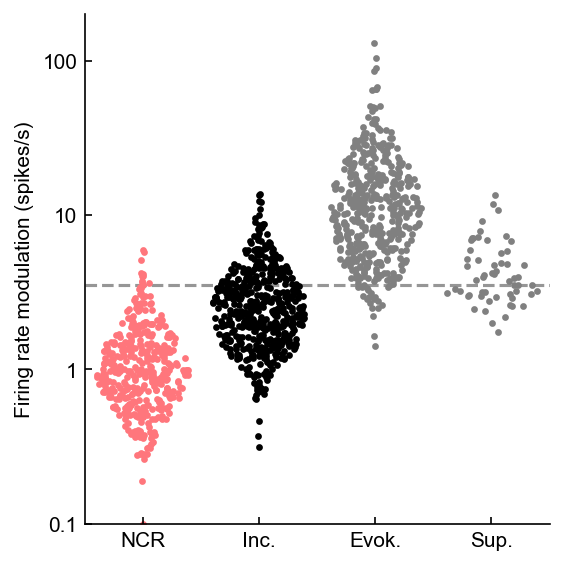

In [46]:
fig, ax = plt.subplots(figsize=(4,4.5))

X,Y = violin(FRmod_NCR,log=True)
ax.scatter(X,Y,s=5,color=NCR_COLOR)

X,Y = violin(FRmod_inc,log=True)
ax.scatter(X+1,Y,s=5,color='k')

X,Y = violin(FRmod_evoked,log=True)
ax.scatter(X+2,Y,s=5,color=CR_COLOR)

X,Y = violin(FRmod_suppressed,log=True)
ax.scatter(X+3,Y,s=5,color=CR_COLOR)




ax.axhline(3.5,linestyle='--',color=GOOD_GREY,zorder=-10)



ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['NCR','Inc.','Evok.','Sup.'])

ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels([str(s) for s in [0.1,1,10,100]])
ax.set_ylabel('Firing rate modulation (spikes/s)')

# Temporary place for choice analysis

In [24]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 592/592 [00:02<00:00, 230.28it/s]


In [35]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in animalPhases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in animalPhases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in animalPhases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1440/1440 [00:07<00:00, 180.73it/s]

errors for: []


In [60]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
        
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postexpert_animals.append(sessionfile.meta.animal)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

1440it [00:08, 178.32it/s]


In [61]:
print(FRmod_preearly)
print(FRmod_prelate)
print(FRmod_preexpert)
print(FRmod_postearly)
print(FRmod_postlate)
print(FRmod_postexpert)

[-1.07042545e+00 -2.56867983e-01 -2.04835194e-01  1.84176151e-01
 -2.44817220e-01  1.18635709e-01 -9.14419616e-02 -1.52867437e-02
 -4.09627067e-01  1.79275186e-01  1.83551083e-01  8.84837663e-02
 -3.18471110e-01 -3.59094694e-01 -2.70689856e-01  3.60965185e-02
  4.18557277e-02 -9.59199862e-02 -1.86331066e-01  2.10722543e-01
 -5.16876304e-01  5.24469952e-02  2.04009688e-01 -2.78741612e-01
  2.66753784e-01 -3.99861230e-01  3.03610658e-01 -1.17447357e-01
 -4.80130139e-02  1.30192953e+00  2.96277215e-02 -3.45438348e-01
 -9.16414752e-02 -3.80098143e-02 -2.09742565e-01 -1.64666347e-01
 -3.14536313e-01 -4.59969256e-01 -5.40007351e-01 -3.65658841e-01
 -3.45071216e-01 -1.82099567e-01 -7.97340665e-02 -3.85589278e-01
  5.04633298e-02  7.49579305e-02 -2.60967148e-01 -1.47586542e-01
 -3.18435020e-02 -5.08158582e-01 -4.33738529e-01  7.62585450e-01
  1.90272277e+01 -4.04383613e-01  5.05377492e-01 -1.08393110e+00
  5.91220181e-01 -3.73344601e-01  2.99769012e-01 -3.99000899e-01
 -9.67737829e-01 -1.18821

baseline = 0.27873712903822867


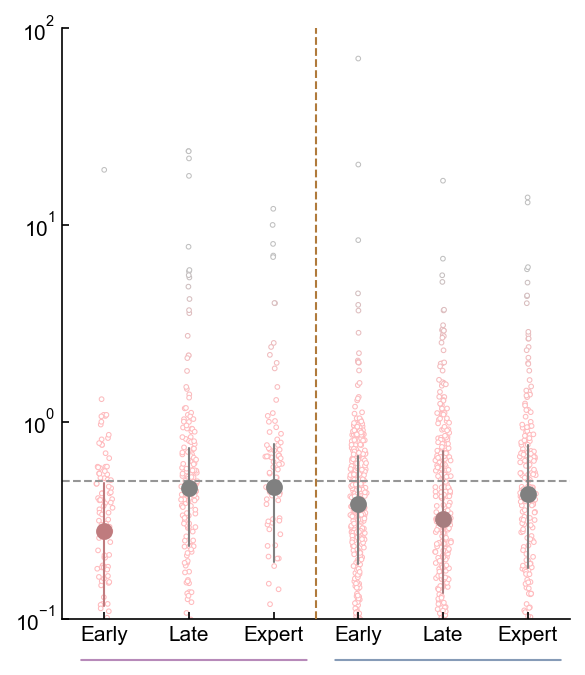

In [69]:
#Firing rate modulation graphs
size=5

FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
data = [np.abs(d) for d in data]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    border_color = eye_color
    
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
#     border_color=colorsys.hls_to_rgb(h,l*0.5,s)
#     print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
#
ax.set_ylim([0.1,100])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])
#ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))

ax.axhline(0.5,linestyle='--',color=GOOD_GREY,zorder=-4,lw=1)
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
#ax.text(xtick_pos_pre, 159.8588155862021, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
#ax.text(xtick_pos_post, 159.8588155862021, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color=PHASE_COLORS[1]))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color=PHASE_COLORS[4]))

plt.tight_layout()
#fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC FRmodulation all cells over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")